## Setup

In [1]:
%matplotlib inline

In [2]:
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BankDataset

In [3]:
from aif360.datasets import StandardDataset
StandardDataset??

In [4]:
import sys
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import pandas as pd
import statistics
from data_utils import DatasetBuilder
from metrics_utils import compute_metrics, describe_metrics, get_test_metrics, test
from plot_utils import plot
from mitigators import NullMitigator, SyntheticMitigator, DIRMitigator, ReweighMitigator, EGMitigator, PRMitigator, CPPMitigator, ROMitigator 
from test_algorithms import TestAlgorithms
from plot_utils import plot_algo_lr, plot_algo

# Metrics
from aif360.metrics import BinaryLabelDatasetMetric

# Bias insertion
from oversample import label_bias, selection_bias 
from metrics_utils import get_orig_model_metrics

from sklearn import preprocessing

# Privacy Meter
from privacy_meter.dataset import Dataset

from aif360.datasets import BinaryLabelDataset

In [5]:
import os
import shutil
import glob

## Arguments & Initializations

In [6]:
# construct argument parser
import argparse
ap = argparse.ArgumentParser()
ap.add_argument("-d", "--data", choices=['adult', 'compas', 'german', 'bank', 'meps19', 'grade', 'law_sex'], default='compas', help="dataset: adult, compas, german, bank, meps19, grade")
ap.add_argument("-c", "--classifier", choices=['lr', 'rf', 'svm', 'nn', 'nb'], default='lr', help="baseline model: lr, rf, svm, nn, nb, dt")
ap.add_argument("-m", "--mitigator", choices=['dir', 'rew', 'egr', 'pr', 'cpp', 'ro'], required=False, help="mitigators: dir, rew, egr, pr, cpp, ro")
ap.add_argument("-b", "--bias", default=0., help="amount of bias: o-1")
ap.add_argument("-t", "--biastype", choices=['label', 'selection', 'none'], default='none', help="amount of bias: o-1")
ap.add_argument("-o", "--os", default=2, help="oversample mode: 1: privi unfav 2: unpriv fav")
ap.add_argument("-a", "--attack", choices=['mia1', 'mia2'], default='mia1', help="attacks: our implementation, their implementation")

_StoreAction(option_strings=['-a', '--attack'], dest='attack', nargs=None, const=None, default='mia1', type=None, choices=['mia1', 'mia2'], required=False, help='attacks: our implementation, their implementation', metavar=None)

In [7]:
import sys
sys.argv = ['']
args = vars(ap.parse_args())

In [8]:
args

{'data': 'compas',
 'classifier': 'lr',
 'mitigator': None,
 'bias': 0.0,
 'biastype': 'none',
 'os': 2,
 'attack': 'mia1'}

In [9]:
DATASET = "law_gender_aif"#args["data"]
BASELINE = "dt" #args["classifier"]
MITIGATOR = args["mitigator"]
BIAS = float(args["bias"])
BIAS_TYPE = args["biastype"]
OS_MODE = int(args["os"])
ATTACK = "mia2"

In [10]:
# global constants
if BASELINE == 'svm' or BASELINE == 'nn':
    SCALER = False 
else:
    SCALER = False 
DISPLAY = False 
THRESH_ARR = 0.5

# loop ten times 
N = 20

# percentage of favor and unfavor
priv_metric_orig = defaultdict(float)
favor_metric_orig = defaultdict(float)
favor_metric_transf = defaultdict(float)

# for each pre-processing approach, we create a mia_metric_results
orig_metrics = defaultdict(list)
orig_mia_metrics = defaultdict(list)

transf_metrics = defaultdict(list) 
transf_mia_metrics = defaultdict(list) 

reweigh_metrics = defaultdict(list) 
reweigh_mia_metrics = defaultdict(list) 

dir_metrics = defaultdict(list) 
dir_mia_metrics = defaultdict(list) 

eg_metrics = defaultdict(list) 
eg_mia_metrics = defaultdict(list) 


pr_orig_metrics = defaultdict(list) 
cpp_metrics = defaultdict(list) 
ro_metrics = defaultdict(list) 

In [11]:
ATTACK

'mia2'

## Loading & Splitting Dataset

In [12]:
# load dataset and set the groups
dataset_builder =  DatasetBuilder(DATASET)
dataset_orig = dataset_builder.load_data()
sens_attr = dataset_orig.protected_attribute_names[0]
unprivileged_groups = dataset_builder.unprivileged_groups
privileged_groups = dataset_builder.privileged_groups

In [13]:
dataset_orig.features.shape

(22342, 4)

In [14]:
privileged_groups

[{'gender': 1}]

In [15]:
sens_attr

'gender'

In [16]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

In [17]:
if ATTACK == "mia1":
    # training data split ratio
    p = 0.5
    # split dataset into train, validation, and test
    dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
    dataset_orig_val = dataset_orig_test
    print(dataset_orig_train.features)

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')
        
    dataset_orig_train
    dataset_orig_train?

## Run Mitigating Algorithms

### Setup for MIA2

In [18]:
seed = 1234
np.random.seed(seed)

In [19]:
if ATTACK == "mia2":
    # prepare data format
    X = dataset_orig.features
    y_true = dataset_orig.labels.ravel()
    sens_attr = dataset_orig.protected_attribute_names[0]
    sens_attr_index = dataset_orig.feature_names.index(sens_attr)
    sensitive_features = dataset_orig.features[:, sens_attr_index]

    X_other_features = np.delete(X, sens_attr_index, axis=1)
    X_other_features_normalized = preprocessing.normalize(X_other_features, norm='l2')

    # Reconstruct X by combining the sensitive attribute and the normalized features
    # Insert the sensitive attribute back into its original position
    X_normalized = np.insert(X_other_features_normalized, sens_attr_index, sensitive_features, axis=1)
    X = X_normalized

In [20]:
def get_unique_indices_reference():
    # Determine split sizes proportionally (to sum up to the full dataset size)
    num_train_points = int(X.shape[0] * 0.12)
    num_test_points = int(X.shape[0] * 0.12)
    num_population_points = int(X.shape[0] * 0.3)  # Reduced from 30000

    # Start with all indices
    all_indices = np.arange(X.shape[0])

    # Select train indices without replacement
    train_index = np.random.choice(all_indices, num_train_points, replace=False)
    # Remove train indices from available indices
    remaining_indices = np.setdiff1d(all_indices, train_index)

    # Select test indices from the remaining indices without replacement
    test_index = np.random.choice(remaining_indices, num_test_points, replace=False)
    # Remove test indices from available indices
    remaining_indices = np.setdiff1d(remaining_indices, test_index)

    # Select population indices from the remaining indices (can also choose all remaining points)
    population_index = np.random.choice(remaining_indices, min(num_population_points, len(remaining_indices)), replace=False)

    # Summary of counts
    print("==============================================================")
    print("GET UNIQUE INDICES REFERENCE")
    print(f"Number of train points: {len(train_index)}")
    print(f"Number of test points: {len(test_index)}")
    print(f"Number of population points: {len(population_index)}")
    print("==============================================================")
    
    return train_index, test_index, population_index

In [21]:
def create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train):
    # create the target model's dataset
    train_ds = {'x': X[train_index], 'y': y_true[train_index],'g':g_train}
    test_ds = {'x': X[test_index], 'y': y_true[test_index], 'g':g_test}
    target_dataset = Dataset(
        data_dict={'train': train_ds, 'test': test_ds},
        default_input='x', default_output='y', default_group='g'
    )

    # create the reference dataset
    population_ds = {'x': X[population_index], 'y': y_true[population_index], 'g': g_pop_train}
    reference_dataset = Dataset(
        data_dict={'train': population_ds},
        default_input='x', default_output='y', default_group='g'
    )
    
    return target_dataset, reference_dataset

In [22]:
# Combine features, labels, and protected attributes into a DataFrame
def create_binary_label_dataset(dataset_orig, X, y, sensitive_features, sens_attr_name, privileged_value, unprivileged_value):
    print("=====================================================")
    print("CREATE BINARY LABEL DATASET")
    # Extract the feature names from the original dataset
    feature_names = dataset_orig.feature_names

    # Create a DataFrame with features, labels, and sensitive attribute
    df = pd.DataFrame(X, columns=feature_names)
    df[dataset_orig.label_names[0]] = y
#     df[sens_attr_name] = sensitive_features

    print(df.head())
    # print(dataset_orig.feature_names)
    # print(dataset_orig.features.shape)
    
    # df_orig, _ = dataset_orig.convert_to_dataframe()

    # # Display the first few rows
    # print("Original df's head:", df_orig.head())
    
    # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset_orig.labels, return_counts=True)

    # # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")

    # Create the BinaryLabelDataset
    dataset = BinaryLabelDataset(
        favorable_label=1.0,  # Adjust as per your dataset
        unfavorable_label=0.0,  # Adjust as per your dataset
        df=df,  # DataFrame containing features, labels, and protected attribute
        label_names=dataset_orig.label_names,  # Column name of labels in DataFrame
        protected_attribute_names=[sens_attr_name],  # Protected attribute column
        privileged_protected_attributes=[privileged_value],  # Privileged group values
        unprivileged_protected_attributes=[unprivileged_value]  # Unprivileged group values
    )
    
    # print(dataset.feature_names)
    # print(dataset.features.shape)
    # # Get the unique labels and their counts
    # unique_labels, counts = np.unique(dataset.labels, return_counts=True)

    # Print the value counts
    # for label, count in zip(unique_labels, counts):
    #     print(f"Label {label}: {count} instances")
    
    print("=====================================================")
    
    return dataset

In [23]:
def delete_logs():
    # Search for directories ending with _group or _pop
    for pattern in ["*_group", "*_pop"]:
        # Find matching directories
        for log_dir in glob.glob(pattern):
            if os.path.exists(log_dir) and os.path.isdir(log_dir):  # Ensure it's a directory
                shutil.rmtree(log_dir)
                print(f"{log_dir} deleted.")

### Calling Both

In [24]:
target_dataset = None
reference_dataset = None

In [25]:
# favorable and unfavorable labels and feature_names
f_label = dataset_orig.favorable_label
uf_label = dataset_orig.unfavorable_label
feature_names = dataset_orig.feature_names

# run mitigating algorithms
for i in range(N):
    if ATTACK == "mia1":
        # split dataset into train, validation, and test
        dataset_orig_train, dataset_orig_test = dataset_orig.split([p], shuffle=True)
        dataset_orig_val = dataset_orig_test

        print("#### Train dataset's features are as below:")
        print(dataset_orig_train.features)
    elif ATTACK == "mia2":
        train_index, test_index, population_index = get_unique_indices_reference()
        
        g_train = y_true[train_index] + (sensitive_features[train_index] + 1) * 2 # 2, 4, 3, 5
        g_test = y_true[test_index] + (sensitive_features[test_index] + 1) * 2
        g_pop_train = y_true[population_index] + (sensitive_features[population_index] + 1) * 2
        
        # for Audit
        target_dataset, reference_dataset = create_datasets(train_index, test_index, population_index, g_train, g_test, g_pop_train)
        
        # for mitigators
        privileged_value = [1]
        unprivileged_value = [0]
        # Convert train dataset
        dataset_orig_train = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[train_index],
            y=y_true[train_index],
            sensitive_features=sensitive_features[train_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        # Convert test dataset
        dataset_orig_val = create_binary_label_dataset(
            dataset_orig=dataset_orig,
            X=X[test_index],
            y=y_true[test_index],
            sensitive_features=sensitive_features[test_index],
            sens_attr_name=sens_attr,
            privileged_value=privileged_value,
            unprivileged_value=unprivileged_value
        )
        
        # Since validation and testing datasets are the same
        dataset_orig_test = dataset_orig_val
        
        # orig_metrics, orig_mia_metrics, priv_metric_orig, favor_metric_orig = run_MIA2(dataset_orig, target_dataset, reference_dataset, privileged_groups, unprivileged_groups, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, THRESH_ARR, DISPLAY, SCALER)
        
    # favorable and unfavorable labels and feature_names
    f_label = dataset_orig.favorable_label
    uf_label = dataset_orig.unfavorable_label
    feature_names = dataset_orig.feature_names

    # introduce label or selection biases, assuming the original data is fair
    if BIAS_TYPE == 'label':
        dataset_orig_train = label_bias(dataset_orig_train, unprivileged_groups, BIAS)
    elif BIAS_TYPE == 'selection':
        dataset_orig_train = selection_bias(dataset_orig_train, unprivileged_groups, BIAS)
    else:
        print('no bias type specified')

    # show data info
    print("#### Training Dataset shape")
    print(dataset_orig_train.features.shape)
    print("#### Favorable and unfavorable labels")
    print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
    print("#### Protected attribute names")
    print(dataset_orig_train.protected_attribute_names)
    print("#### Privileged and unprivileged protected groups")
    print(privileged_groups, unprivileged_groups)
    print("#### Privileged and unprivileged protected attribute values")
    print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
    print("#### Dataset feature names")
    print(dataset_orig_train.feature_names)

    # check fairness on the original data
    metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
    print("privileged vs. unprivileged: ", metric_orig_train.num_positives(privileged=True) + metric_orig_train.num_negatives(privileged=True), metric_orig_train.num_positives(privileged=False) + metric_orig_train.num_negatives(privileged=False)) 
    base_rate_unprivileged = metric_orig_train.base_rate(privileged=False)
    base_rate_privileged = metric_orig_train.base_rate(privileged=True)
    print('base_pos unpriv: ', base_rate_unprivileged)
    print('base_pos priv: ', base_rate_privileged)
    print('number of favorable labels: ', np.count_nonzero(dataset_orig_train.labels==f_label))
    print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

    # statistics of favored/positive class BEFORE transf 
    priv_metric_orig['total_priv'] += metric_orig_train.num_instances(privileged = True) 
    priv_metric_orig['total_unpriv'] += metric_orig_train.num_instances(privileged = False) 
    favor_metric_orig['total_favor'] += metric_orig_train.base_rate()
    favor_metric_orig['total_unfavor'] += 1 - metric_orig_train.base_rate()
    favor_metric_orig['priv_favor'] += metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['priv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = True)
    favor_metric_orig['unpriv_favor'] += metric_orig_train.base_rate(privileged = False)
    favor_metric_orig['unpriv_unfavor'] += 1 - metric_orig_train.base_rate(privileged = False)

    print("#### Train shape, validation shape, test shape")
    print(dataset_orig_train.features.shape, dataset_orig_val.features.shape, dataset_orig_test.features.shape)

    # testing mitigation methods 
    test_cases = TestAlgorithms(BASELINE)

    # null mitigator
    orig_metrics, orig_mia_metrics = test_cases.run_original(dataset_orig_train, dataset_orig_val, dataset_orig_test, BASELINE, orig_metrics, orig_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 

    # synthetic data mitigator
    metric_transf_train, transf_metrics, transf_mia_metrics = test_cases.run_oversample(dataset_orig_train, dataset_orig_val, dataset_orig_test, privileged_groups, unprivileged_groups, base_rate_privileged, base_rate_unprivileged, BASELINE, transf_metrics, transf_mia_metrics, f_label, uf_label, ATTACK, THRESH_ARR, DISPLAY, OS_MODE, SCALER, target_dataset, reference_dataset)
    
    # statistics of favored/positive class AFTER transf
    favor_metric_transf['total_favor'] += metric_transf_train.base_rate()
    favor_metric_transf['total_unfavor'] += 1 - metric_transf_train.base_rate()
    favor_metric_transf['priv_favor'] += metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['priv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = True)
    favor_metric_transf['unpriv_favor'] += metric_transf_train.base_rate(privileged = False)
    favor_metric_transf['unpriv_unfavor'] += 1 - metric_transf_train.base_rate(privileged = False)

    # dir mitigator
    dir_metrics, dir_mia_metrics = test_cases.run_dir(dataset_orig_train, dataset_orig_val, dataset_orig_test,  sens_attr, BASELINE, dir_metrics, dir_mia_metrics, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset) 
    
    # reweigh mitigator
    reweigh_metrics, reweigh_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, reweigh_metrics, reweigh_mia_metrics, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)

    # eg mitigator, in-processing
    eg_metrics, eg_mia_metrics = test_cases.run_eg(dataset_orig_train, dataset_orig_val, dataset_orig_test, eg_metrics, eg_mia_metrics, BASELINE, f_label, uf_label, unprivileged_groups, privileged_groups, ATTACK, THRESH_ARR, DISPLAY, SCALER, target_dataset, reference_dataset)
#     # egr gave error so I replaced it with reweigh
# #     eg_metrics, eg_mia_metrics = test_cases.run_rew(dataset_orig_train, dataset_orig_val, dataset_orig_test, f_label, uf_label,  unprivileged_groups, privileged_groups, BASELINE, eg_metrics, eg_mia_metrics, THRESH_ARR, DISPLAY, SCALER)

#     # cpp mitigator
#     cpp_metrics = test_cases.run_cpp(dataset_orig_train, dataset_orig_val, dataset_orig_test, cpp_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

#     # ro mitigator
#     # ro_metrics = test_cases.run_ro(dataset_orig_train, dataset_orig_val, dataset_orig_test, ro_metrics, BASELINE, unprivileged_groups, privileged_groups, THRESH_ARR, SCALER)

#     if (BASELINE == 'lr'):
#         pr_orig_metrics = test_cases.run_pr(dataset_orig_train, dataset_orig_val, dataset_orig_test, pr_orig_metrics, sens_attr, f_label, uf_label, unprivileged_groups, privileged_groups, THRESH_ARR, DISPLAY, SCALER) 

    delete_logs()

GET UNIQUE INDICES REFERENCE
Number of train points: 2681
Number of test points: 2681
Number of population points: 6702
CREATE BINARY LABEL DATASET
       race  gender      lsat      ugpa  gpa_class
0  0.641683     0.0  0.554969  0.529388        1.0
1  0.669538     0.0  0.434295  0.602584        0.0
2  0.671169     0.0  0.544191  0.503377        1.0
3  0.703765     1.0  0.475517  0.527824        0.0
4  0.731375     1.0  0.405221  0.548531        0.0
CREATE BINARY LABEL DATASET
       race  gender      lsat      ugpa  gpa_class
0  0.718799     0.0  0.514815  0.467219        0.0
1  0.709309     1.0  0.392995  0.585180        1.0
2  0.665479     1.0  0.539577  0.515746        1.0
3  0.652409     0.0  0.458450  0.603478        0.0
4  0.000000     0.0  0.635777  0.771873        0.0
no bias type specified
#### Training Dataset shape
(2681, 4)
#### Favorable and unfavorable labels
1.0 0.0
#### Protected attribute names
['gender']
#### Privileged and unprivileged protected groups
[{'gender': 1

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.22159196]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.64
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.09
  Positive predictive value: 0.58
  Optimal thershold: [0.5389965]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 829, Test = 851
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.53
  Test Accuracy (TNR): 0.53
  Attacker advantage: 0.07
  Positive predictive value: 0.53
  Optimal thershold: [0.45953233]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 314, Test = 353
  AUC: 0.61
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.35
  Test Accuracy (TNR): 0.78
  Attacker advantage: 0.17
  Positive predictive value: 1.00
  Optimal thershold: [1.34373475]
)
MIA_Result(
  Name: subpopulation_1.0_labe

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.26826399]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.10
  Positive predictive value: 0.57
  Optimal thershold: [0.62860866]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 829, Test = 851
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.66
  Test Accuracy (TNR): 0.43
  Attacker advantage: 0.09
  Positive predictive value: 0.53
  Optimal thershold: [0.35667494]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 314, Test = 353
  AUC: 0.64
  Privacy Risk: 0.61
  Accuracy: 0.61
  Train Accuracy (TPR): 0.66
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.22
  Positive predictive value: 0.69
  Optimal thershold: [1.15396238]
)
MIA_Result(
  Name: subpopulation_1.0_l

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.22314355]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.07
  Positive predictive value: 0.57
  Optimal thershold: [0.62730061]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 829, Test = 851
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.36
  Test Accuracy (TNR): 0.71
  Attacker advantage: 0.08
  Positive predictive value: 0.56
  Optimal thershold: [0.49674088]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 314, Test = 353
  AUC: 0.64
  Privacy Risk: 0.62
  Accuracy: 0.61
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.54
  Attacker advantage: 0.24
  Positive predictive value: 1.00
  Optimal thershold: [1.23474446]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values wi

Best thresh:  [0.22159196]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.64
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.09
  Positive predictive value: 0.58
  Optimal thershold: [0.5389965]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 829, Test = 851
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.53
  Test Accuracy (TNR): 0.53
  Attacker advantage: 0.07
  Positive predictive value: 0.53
  Optimal thershold: [0.45953233]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 314, Test = 353
  AUC: 0.61
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.35
  Test Accuracy (TNR): 0.78
  Attacker advantage: 0.17
  Positive predictive value: 1.00
  Optimal thershold: [1.34373475]
)
MIA_Result(
  Name: subpopulation_1.0_la

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:304:

Best thresh:  [0.14344874]
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.64
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.10
  Positive predictive value: 0.57
  Optimal thershold: [0.05109089]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 829, Test = 851
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.57
  Test Accuracy (TNR): 0.53
  Attacker advantage: 0.10
  Positive predictive value: 0.54
  Optimal thershold: [0.0408492]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 314, Test = 353
  AUC: 0.66
  Privacy Risk: 0.60
  Accuracy: 0.61
  Train Accuracy (TPR): 0.50
  Test Accuracy (TNR): 0.71
  Attacker advantage: 0.22
  Positive predictive value: 0.73
  Optimal thershold: [0.15257361]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.25593337]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.07
  Positive predictive value: 0.55
  Optimal thershold: [0.77932488]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 789, Test = 789
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.21
  Attacker advantage: 0.08
  Positive predictive value: 0.54
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 352, Test = 355
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.82
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.13
  Positive predictive value: 0.65
  Optimal thershold: [1.30770409]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.27193372]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.07
  Positive predictive value: 0.57
  Optimal thershold: [0.7750643]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 789, Test = 789
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.06
  Positive predictive value: 0.59
  Optimal thershold: [0.36772478]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 352, Test = 355
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.24
  Attacker advantage: 0.14
  Positive predictive value: 0.67
  Optimal thershold: [1.79175947]
)
MIA_Result(
  Name: subpopulation_1.0_la

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.28768207]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR): 0.21
  Attacker advantage: 0.08
  Positive predictive value: 0.54
  Optimal thershold: [0.94446161]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 789, Test = 789
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.43
  Test Accuracy (TNR): 0.61
  Attacker advantage: 0.05
  Positive predictive value: 0.55
  Optimal thershold: [0.23440071]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 352, Test = 355
  AUC: 0.60
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.90
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.19
  Positive predictive value: 0.64
  Optimal thershold: [1.38629436]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this w

Best thresh:  [0.25593337]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.07
  Positive predictive value: 0.55
  Optimal thershold: [0.77932488]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 789, Test = 789
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.21
  Attacker advantage: 0.08
  Positive predictive value: 0.54
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 352, Test = 355
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.82
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.13
  Positive predictive value: 0.65
  Optimal thershold: [1.30770409]
)
MIA_Result(
  Name: subpopulation_1.0_l

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:304: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: Use

Best thresh:  [9.09090954e-09]
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.21
  Attacker advantage: 0.08
  Positive predictive value: 0.54
  Optimal thershold: [0.09398759]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 789, Test = 789
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.10
  Positive predictive value: 0.54
  Optimal thershold: [0.04560305]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 352, Test = 355
  AUC: 0.62
  Privacy Risk: 0.61
  Accuracy: 0.61
  Train Accuracy (TPR): 0.76
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.21
  Positive predictive value: 1.00
  Optimal thershold: [0.1126022]
)
MIA_Result(
  Name: subpopulation_1.0_label_

C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:134: RuntimeWarning: divide by zero encountered in scalar divide
  metric_arrs['disp_imp'].append(1 - min((metric.disparate_impact()), 1/metric.disparate_impact()))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.23419339]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.76
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.08
  Positive predictive value: 0.56
  Optimal thershold: [0.76546784]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 822, Test = 812
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.21
  Attacker advantage: 0.05
  Positive predictive value: 0.57
  Optimal thershold: [0.52129692]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 332, Test = 344
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.16
  Positive predictive value: 0.75
  Optimal thershold: [1.178655]
)
MIA_Result(
  Name: subpopulation_1.0_label

C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:134: RuntimeWarning: divide by zero encountered in scalar divide
  metric_arrs['disp_imp'].append(1 - min((metric.disparate_impact()), 1/metric.disparate_impact()))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.2006707]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.07
  Positive predictive value: 0.55
  Optimal thershold: [0.78845736]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 822, Test = 812
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.52
  Test Accuracy (TNR): 0.53
  Attacker advantage: 0.05
  Positive predictive value: 0.55
  Optimal thershold: [0.35667494]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 332, Test = 344
  AUC: 0.59
  Privacy Risk: 0.58
  Accuracy: 0.57
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.15
  Positive predictive value: 0.62
  Optimal thershold: [1.178655]
)
MIA_Result(
  Name: subpopulation_1.0_labe

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.22705745]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.08
  Positive predictive value: 0.55
  Optimal thershold: [0.62860866]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 822, Test = 812
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.22
  Attacker advantage: 0.05
  Positive predictive value: 0.52
  Optimal thershold: [0.55961579]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 332, Test = 344
  AUC: 0.62
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.55
  Test Accuracy (TNR): 0.63
  Attacker advantage: 0.18
  Positive predictive value: 0.74
  Optimal thershold: [1.44691898]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:134: RuntimeWarning: divide by zero encountered in scalar divide
  metric_arrs['disp_imp'].append(1 - min((metric.disparate_impact()), 1/metric.disparate_impact()))
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3

Best thresh:  [0.25782911]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.76
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.08
  Positive predictive value: 0.55
  Optimal thershold: [0.76546784]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 822, Test = 812
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.53
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.05
  Positive predictive value: 0.56
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 332, Test = 344
  AUC: 0.60
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.49
  Attacker advantage: 0.16
  Positive predictive value: 0.75
  Optimal thershold: [1.178655]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:304: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: Use

Best thresh:  [9.09090954e-09]
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.56
  Test Accuracy (TNR): 0.52
  Attacker advantage: 0.08
  Positive predictive value: 0.57
  Optimal thershold: [0.0409584]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 822, Test = 812
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.64
  Attacker advantage: 0.08
  Positive predictive value: 0.56
  Optimal thershold: [0.02339019]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 332, Test = 344
  AUC: 0.62
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.19
  Positive predictive value: 0.83
  Optimal thershold: [0.13373325]
)
MIA_Result(
  Name: subpopulation_1.0_label_

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.31845373]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.50
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.07
  Positive predictive value: 0.57
  Optimal thershold: [0.44183275]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 841, Test = 847
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.38
  Test Accuracy (TNR): 0.71
  Attacker advantage: 0.10
  Positive predictive value: 0.58
  Optimal thershold: [0.21205872]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 336, Test = 332
  AUC: 0.61
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.48
  Attacker advantage: 0.18
  Positive predictive value: 0.79
  Optimal thershold: [1.12846525]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.33024169]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.50
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.08
  Positive predictive value: 0.57
  Optimal thershold: [0.45198512]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 841, Test = 847
  AUC: 0.56
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.55
  Test Accuracy (TNR): 0.56
  Attacker advantage: 0.11
  Positive predictive value: 0.56
  Optimal thershold: [0.3254224]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 336, Test = 332
  AUC: 0.63
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.40
  Test Accuracy (TNR): 0.78
  Attacker advantage: 0.18
  Positive predictive value: 0.79
  Optimal thershold: [0.80562516]
)
MIA_Result(
  Name: subpopulation_1.0_la

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.26236426]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.40
  Test Accuracy (TNR): 0.66
  Attacker advantage: 0.06
  Positive predictive value: 0.59
  Optimal thershold: [0.37138109]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 841, Test = 847
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.61
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.07
  Positive predictive value: 0.60
  Optimal thershold: [0.37138109]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 336, Test = 332
  AUC: 0.62
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.35
  Test Accuracy (TNR): 0.81
  Attacker advantage: 0.17
  Positive predictive value: 0.83
  Optimal thershold: [0.92219045]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values wi

Best thresh:  [0.31845373]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.50
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.07
  Positive predictive value: 0.57
  Optimal thershold: [0.44183275]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 841, Test = 847
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.38
  Test Accuracy (TNR): 0.71
  Attacker advantage: 0.10
  Positive predictive value: 0.58
  Optimal thershold: [0.21205872]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 336, Test = 332
  AUC: 0.61
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.48
  Attacker advantage: 0.18
  Positive predictive value: 0.79
  Optimal thershold: [1.12846525]
)
MIA_Result(
  Name: subpopulation_1.0_l

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:304:

Best thresh:  [7.1428575e-09]
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.50
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.07
  Positive predictive value: 0.59
  Optimal thershold: [0.03079976]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 841, Test = 847
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.45
  Test Accuracy (TNR): 0.63
  Attacker advantage: 0.08
  Positive predictive value: 0.59
  Optimal thershold: [0.01672882]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 336, Test = 332
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.37
  Test Accuracy (TNR): 0.79
  Attacker advantage: 0.16
  Positive predictive value: 0.86
  Optimal thershold: [0.06794245]
)
MIA_Result(
  Name: subpopulation_1.0_label_

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.29849299]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.07
  Positive predictive value: 0.55
  Optimal thershold: [0.51843022]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 819, Test = 806
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.38
  Attacker advantage: 0.09
  Positive predictive value: 0.55
  Optimal thershold: [0.45643155]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 321, Test = 319
  AUC: 0.58
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.66
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.12
  Positive predictive value: 0.58
  Optimal thershold: [1.09002854]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.35667494]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.42
  Test Accuracy (TNR): 0.64
  Attacker advantage: 0.06
  Positive predictive value: 0.56
  Optimal thershold: [0.40546511]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 819, Test = 806
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.82
  Test Accuracy (TNR): 0.26
  Attacker advantage: 0.08
  Positive predictive value: 0.57
  Optimal thershold: [0.47489361]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 321, Test = 319
  AUC: 0.57
  Privacy Risk: 0.56
  Accuracy: 0.55
  Train Accuracy (TPR): 0.45
  Test Accuracy (TNR): 0.66
  Attacker advantage: 0.11
  Positive predictive value: 0.60
  Optimal thershold: [0.81093022]
)
MIA_Result(
  Name: subpopulation_1.0_l

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.18232156]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.43
  Test Accuracy (TNR): 0.64
  Attacker advantage: 0.07
  Positive predictive value: 0.56
  Optimal thershold: [0.38484582]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 819, Test = 806
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.09
  Positive predictive value: 0.55
  Optimal thershold: [0.31845373]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 321, Test = 319
  AUC: 0.63
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.19
  Positive predictive value: 0.69
  Optimal thershold: [1.1411719]
)
MIA_Result(
  Name: subpopulation_1.0_labe

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values wi

Best thresh:  [0.29849299]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.07
  Positive predictive value: 0.55
  Optimal thershold: [0.51843022]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 819, Test = 806
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.38
  Attacker advantage: 0.09
  Positive predictive value: 0.55
  Optimal thershold: [0.45643155]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 321, Test = 319
  AUC: 0.58
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.66
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.12
  Positive predictive value: 0.58
  Optimal thershold: [1.09002854]
)
MIA_Result(
  Name: subpopulation_1.0_l

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:304: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: Use

Best thresh:  [1.25000006e-08]
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.33
  Test Accuracy (TNR): 0.73
  Attacker advantage: 0.06
  Positive predictive value: 0.55
  Optimal thershold: [0.03335532]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 819, Test = 806
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.09
  Positive predictive value: 0.56
  Optimal thershold: [0.05718306]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 321, Test = 319
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.16
  Positive predictive value: 0.62
  Optimal thershold: [0.17203817]
)
MIA_Result(
  Name: subpopulation_1.0_label

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.32257745]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.63
  Test Accuracy (TNR): 0.43
  Attacker advantage: 0.06
  Positive predictive value: 0.56
  Optimal thershold: [0.51082562]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 842, Test = 823
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.56
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.06
  Positive predictive value: 0.56
  Optimal thershold: [0.32257745]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 320, Test = 356
  AUC: 0.57
  Privacy Risk: 0.54
  Accuracy: 0.56
  Train Accuracy (TPR): 0.16
  Test Accuracy (TNR): 0.92
  Attacker advantage: 0.08
  Positive predictive value: 0.65
  Optimal thershold: [0.86499744]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.26157093]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.36
  Attacker advantage: 0.07
  Positive predictive value: 0.56
  Optimal thershold: [0.67916094]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 842, Test = 823
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.62
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.08
  Positive predictive value: 0.58
  Optimal thershold: [0.33921572]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 320, Test = 356
  AUC: 0.62
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.45
  Test Accuracy (TNR): 0.69
  Attacker advantage: 0.16
  Positive predictive value: 0.71
  Optimal thershold: [1.30833282]
)
MIA_Result(
  Name: subpopulation_1.0_l

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.35020243]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.08
  Positive predictive value: 0.56
  Optimal thershold: [0.87546874]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 842, Test = 823
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.48
  Test Accuracy (TNR): 0.60
  Attacker advantage: 0.08
  Positive predictive value: 0.55
  Optimal thershold: [0.17384693]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 320, Test = 356
  AUC: 0.62
  Privacy Risk: 0.58
  Accuracy: 0.60
  Train Accuracy (TPR): 0.34
  Test Accuracy (TNR): 0.82
  Attacker advantage: 0.19
  Positive predictive value: 0.68
  Optimal thershold: [1.245937]
)
MIA_Result(
  Name: subpopulation_1.0_label

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values wi

Best thresh:  [0.32257745]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.63
  Test Accuracy (TNR): 0.43
  Attacker advantage: 0.06
  Positive predictive value: 0.56
  Optimal thershold: [0.51082562]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 842, Test = 823
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.56
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.06
  Positive predictive value: 0.56
  Optimal thershold: [0.32257745]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 320, Test = 356
  AUC: 0.57
  Privacy Risk: 0.54
  Accuracy: 0.56
  Train Accuracy (TPR): 0.16
  Test Accuracy (TNR): 0.92
  Attacker advantage: 0.09
  Positive predictive value: 0.65
  Optimal thershold: [0.86499744]
)
MIA_Result(
  Name: subpopulation_1.0_l

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:304:

Best thresh:  [9.09090954e-09]
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.08
  Positive predictive value: 0.57
  Optimal thershold: [0.09805744]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 842, Test = 823
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.42
  Test Accuracy (TNR): 0.67
  Attacker advantage: 0.09
  Positive predictive value: 0.58
  Optimal thershold: [0.02143604]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 320, Test = 356
  AUC: 0.63
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.57
  Test Accuracy (TNR): 0.63
  Attacker advantage: 0.20
  Positive predictive value: 0.67
  Optimal thershold: [0.10204102]
)
MIA_Result(
  Name: subpopulation_1.0_label

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.33647224]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.62
  Test Accuracy (TNR): 0.45
  Attacker advantage: 0.07
  Positive predictive value: 0.54
  Optimal thershold: [0.55961579]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 868, Test = 836
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.53
  Train Accuracy (TPR): 0.81
  Test Accuracy (TNR): 0.24
  Attacker advantage: 0.06
  Positive predictive value: 0.56
  Optimal thershold: [0.16705408]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 316, Test = 354
  AUC: 0.60
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.31
  Test Accuracy (TNR): 0.83
  Attacker advantage: 0.14
  Positive predictive value: 0.70
  Optimal thershold: [1.2039728]
)
MIA_Result(
  Name: subpopulation_1.0_labe

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.23319389]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.56
  Test Accuracy (TNR): 0.52
  Attacker advantage: 0.07
  Positive predictive value: 0.55
  Optimal thershold: [0.45198512]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 868, Test = 836
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.38
  Attacker advantage: 0.08
  Positive predictive value: 0.56
  Optimal thershold: [0.42526774]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 316, Test = 354
  AUC: 0.58
  Privacy Risk: 0.54
  Accuracy: 0.56
  Train Accuracy (TPR): 0.15
  Test Accuracy (TNR): 0.93
  Attacker advantage: 0.12
  Positive predictive value: 0.92
  Optimal thershold: [1.28003739]
)
MIA_Result(
  Name: subpopulation_1.0_l

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.21741288]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.63
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.10
  Positive predictive value: 0.56
  Optimal thershold: [0.5389965]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 868, Test = 836
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.80
  Test Accuracy (TNR): 0.26
  Attacker advantage: 0.06
  Positive predictive value: 0.57
  Optimal thershold: [0.53165971]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 316, Test = 354
  AUC: 0.60
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.61
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.18
  Positive predictive value: 0.59
  Optimal thershold: [1.22377543]
)
MIA_Result(
  Name: subpopulation_1.0_labe

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values wi

Best thresh:  [0.33647224]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.62
  Test Accuracy (TNR): 0.45
  Attacker advantage: 0.07
  Positive predictive value: 0.54
  Optimal thershold: [0.55961579]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 868, Test = 836
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.53
  Train Accuracy (TPR): 0.81
  Test Accuracy (TNR): 0.24
  Attacker advantage: 0.06
  Positive predictive value: 0.56
  Optimal thershold: [0.16705408]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 316, Test = 354
  AUC: 0.60
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.31
  Test Accuracy (TNR): 0.83
  Attacker advantage: 0.14
  Positive predictive value: 0.70
  Optimal thershold: [1.2039728]
)
MIA_Result(
  Name: subpopulation_1.0_la

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:304: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: Use

Best thresh:  [1.66666675e-08]
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.63
  Test Accuracy (TNR): 0.45
  Attacker advantage: 0.08
  Positive predictive value: 0.55
  Optimal thershold: [0.08999161]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 868, Test = 836
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.54
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.23
  Attacker advantage: 0.06
  Positive predictive value: 0.57
  Optimal thershold: [0.05504391]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 316, Test = 354
  AUC: 0.60
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.62
  Test Accuracy (TNR): 0.53
  Attacker advantage: 0.15
  Positive predictive value: 1.00
  Optimal thershold: [0.17706911]
)
MIA_Result(
  Name: subpopulation_1.0_label

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.33647224]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.36
  Test Accuracy (TNR): 0.69
  Attacker advantage: 0.06
  Positive predictive value: 0.56
  Optimal thershold: [0.33647224]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 831, Test = 846
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.47
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.10
  Positive predictive value: 0.56
  Optimal thershold: [0.34937564]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 342, Test = 308
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.57
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.10
  Positive predictive value: 0.67
  Optimal thershold: [1.83524458]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.45198512]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.49
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.08
  Positive predictive value: 0.56
  Optimal thershold: [0.40546511]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 831, Test = 846
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.66
  Test Accuracy (TNR): 0.45
  Attacker advantage: 0.11
  Positive predictive value: 0.56
  Optimal thershold: [0.40546511]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 342, Test = 308
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.56
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.21
  Attacker advantage: 0.09
  Positive predictive value: 0.67
  Optimal thershold: [1.30429015]
)
MIA_Result(
  Name: subpopulation_1.0_l

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.25131443]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.57
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.63
  Test Accuracy (TNR): 0.48
  Attacker advantage: 0.10
  Positive predictive value: 0.59
  Optimal thershold: [0.51082562]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 831, Test = 846
  AUC: 0.57
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.48
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.10
  Positive predictive value: 0.57
  Optimal thershold: [0.25131443]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 342, Test = 308
  AUC: 0.61
  Privacy Risk: 0.59
  Accuracy: 0.60
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.43
  Attacker advantage: 0.18
  Positive predictive value: 0.74
  Optimal thershold: [1.15267951]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this w

Best thresh:  [0.33647224]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.36
  Test Accuracy (TNR): 0.69
  Attacker advantage: 0.06
  Positive predictive value: 0.56
  Optimal thershold: [0.33647224]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 831, Test = 846
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.47
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.10
  Positive predictive value: 0.56
  Optimal thershold: [0.34937564]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 342, Test = 308
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.57
  Train Accuracy (TPR): 0.96
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.10
  Positive predictive value: 0.67
  Optimal thershold: [1.83524458]
)
MIA_Result(
  Name: subpopulation_1.0_l

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:304:

Best thresh:  [9.09090954e-09]
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.56
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.06
  Positive predictive value: 0.57
  Optimal thershold: [0.04055918]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 831, Test = 846
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.10
  Positive predictive value: 0.57
  Optimal thershold: [0.02966388]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 342, Test = 308
  AUC: 0.58
  Privacy Risk: 0.56
  Accuracy: 0.58
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.20
  Attacker advantage: 0.13
  Positive predictive value: 0.60
  Optimal thershold: [0.1718919]
)
MIA_Result(
  Name: subpopulation_1.0_label_

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.22314355]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0.42
  Attacker advantage: 0.08
  Positive predictive value: 0.55
  Optimal thershold: [0.58377462]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 842, Test = 820
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.04
  Positive predictive value: 0.54
  Optimal thershold: [0.74193734]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 351, Test = 337
  AUC: 0.62
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR): 0.59
  Attacker advantage: 0.19
  Positive predictive value: 0.72
  Optimal thershold: [1.02450432]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.31845373]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.61
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.07
  Positive predictive value: 0.55
  Optimal thershold: [0.59351734]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 842, Test = 820
  AUC: 0.51
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.28
  Attacker advantage: 0.05
  Positive predictive value: 0.53
  Optimal thershold: [0.59351734]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 351, Test = 337
  AUC: 0.58
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.51
  Test Accuracy (TNR): 0.61
  Attacker advantage: 0.12
  Positive predictive value: 0.80
  Optimal thershold: [0.80381275]
)
MIA_Result(
  Name: subpopulation_1.0_l

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.22314355]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.22
  Attacker advantage: 0.07
  Positive predictive value: 0.59
  Optimal thershold: [0.95977584]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 842, Test = 820
  AUC: 0.53
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.22
  Test Accuracy (TNR): 0.86
  Attacker advantage: 0.08
  Positive predictive value: 0.67
  Optimal thershold: [0.08004271]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 351, Test = 337
  AUC: 0.60
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.58
  Test Accuracy (TNR): 0.61
  Attacker advantage: 0.19
  Positive predictive value: 1.00
  Optimal thershold: [1.04145387]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values wi

Best thresh:  [0.22314355]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0.42
  Attacker advantage: 0.08
  Positive predictive value: 0.55
  Optimal thershold: [0.58377462]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 842, Test = 820
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.04
  Positive predictive value: 0.54
  Optimal thershold: [0.74193734]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 351, Test = 337
  AUC: 0.62
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR): 0.59
  Attacker advantage: 0.19
  Positive predictive value: 0.72
  Optimal thershold: [1.02450432]
)
MIA_Result(
  Name: subpopulation_1.0_l

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:304:

Best thresh:  [0.02021382]
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.09
  Positive predictive value: 0.56
  Optimal thershold: [0.09821074]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 842, Test = 820
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.53
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.05
  Positive predictive value: 0.55
  Optimal thershold: [0.09567472]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 351, Test = 337
  AUC: 0.63
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.18
  Positive predictive value: 0.72
  Optimal thershold: [0.12536426]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.28768207]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.07
  Positive predictive value: 0.54
  Optimal thershold: [0.75983856]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 825, Test = 820
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.05
  Positive predictive value: 0.54
  Optimal thershold: [0.28768207]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 361, Test = 367
  AUC: 0.59
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.36
  Test Accuracy (TNR): 0.76
  Attacker advantage: 0.12
  Positive predictive value: 0.62
  Optimal thershold: [0.93581715]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.34092659]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.05
  Positive predictive value: 0.55
  Optimal thershold: [0.72158512]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 825, Test = 820
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.66
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.05
  Positive predictive value: 0.54
  Optimal thershold: [0.36685027]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 361, Test = 367
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0.56
  Train Accuracy (TPR): 0.74
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.13
  Positive predictive value: 0.60
  Optimal thershold: [1.27296568]
)
MIA_Result(
  Name: subpopulation_1.0_l

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.30691343]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.37
  Attacker advantage: 0.07
  Positive predictive value: 0.53
  Optimal thershold: [0.6702347]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 825, Test = 820
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.04
  Positive predictive value: 0.54
  Optimal thershold: [0.37320425]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 361, Test = 367
  AUC: 0.62
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.42
  Test Accuracy (TNR): 0.77
  Attacker advantage: 0.19
  Positive predictive value: 0.68
  Optimal thershold: [0.80709144]
)
MIA_Result(
  Name: subpopulation_1.0_labe

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values wi

Best thresh:  [0.28768207]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.06
  Positive predictive value: 0.54
  Optimal thershold: [0.75983856]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 825, Test = 820
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.53
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.11
  Attacker advantage: 0.05
  Positive predictive value: 0.54
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 361, Test = 367
  AUC: 0.58
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.35
  Test Accuracy (TNR): 0.77
  Attacker advantage: 0.12
  Positive predictive value: 0.62
  Optimal thershold: [0.93581715]
)
MIA_Result(
  Name: subpopulation_1.0_l

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:304:

Best thresh:  [0.02914633]
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.06
  Positive predictive value: 0.60
  Optimal thershold: [0.08492129]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 825, Test = 820
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.04
  Positive predictive value: 0.54
  Optimal thershold: [0.07425554]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 361, Test = 367
  AUC: 0.58
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.36
  Test Accuracy (TNR): 0.76
  Attacker advantage: 0.12
  Positive predictive value: 0.62
  Optimal thershold: [0.10748092]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.24561641]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.08
  Positive predictive value: 0.54
  Optimal thershold: [0.78015856]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 847, Test = 790
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.55
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.08
  Positive predictive value: 0.55
  Optimal thershold: [0.40546511]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 326, Test = 339
  AUC: 0.62
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.49
  Attacker advantage: 0.19
  Positive predictive value: 0.62
  Optimal thershold: [1.35066718]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.21130909]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.63
  Test Accuracy (TNR): 0.44
  Attacker advantage: 0.07
  Positive predictive value: 0.53
  Optimal thershold: [0.54654371]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 847, Test = 790
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.54
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.23
  Attacker advantage: 0.07
  Positive predictive value: 0.55
  Optimal thershold: [0.56752097]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 326, Test = 339
  AUC: 0.61
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.63
  Test Accuracy (TNR): 0.55
  Attacker advantage: 0.18
  Positive predictive value: 0.60
  Optimal thershold: [1.2039728]
)
MIA_Result(
  Name: subpopulation_1.0_la

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.26236426]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.66
  Test Accuracy (TNR): 0.42
  Attacker advantage: 0.08
  Positive predictive value: 0.54
  Optimal thershold: [0.63907996]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 847, Test = 790
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.55
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.21
  Attacker advantage: 0.08
  Positive predictive value: 0.55
  Optimal thershold: [0.63907996]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 326, Test = 339
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.49
  Attacker advantage: 0.17
  Positive predictive value: 0.69
  Optimal thershold: [1.43508453]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values wi

Best thresh:  [0.24561641]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.08
  Positive predictive value: 0.54
  Optimal thershold: [0.78015856]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 847, Test = 790
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.55
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.08
  Positive predictive value: 0.55
  Optimal thershold: [0.40546511]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 326, Test = 339
  AUC: 0.62
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.19
  Positive predictive value: 0.62
  Optimal thershold: [1.35066718]
)
MIA_Result(
  Name: subpopulation_1.0_l

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:304:

Best thresh:  [9.09090954e-09]
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.37
  Attacker advantage: 0.08
  Positive predictive value: 0.54
  Optimal thershold: [0.05628675]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 847, Test = 790
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.55
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.08
  Positive predictive value: 0.55
  Optimal thershold: [0.0334746]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 326, Test = 339
  AUC: 0.63
  Privacy Risk: 0.61
  Accuracy: 0.60
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.21
  Positive predictive value: 0.67
  Optimal thershold: [0.12079427]
)
MIA_Result(
  Name: subpopulation_1.0_label_

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.22314355]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.07
  Positive predictive value: 0.56
  Optimal thershold: [0.7576857]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 791, Test = 801
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.08
  Positive predictive value: 0.55
  Optimal thershold: [0.7576857]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 346, Test = 322
  AUC: 0.62
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.66
  Test Accuracy (TNR): 0.51
  Attacker advantage: 0.18
  Positive predictive value: 0.77
  Optimal thershold: [0.91629073]
)
MIA_Result(
  Name: subpopulation_1.0_label

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.2006707]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.62
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.08
  Positive predictive value: 0.57
  Optimal thershold: [0.55681074]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 791, Test = 801
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.09
  Positive predictive value: 0.55
  Optimal thershold: [0.91629073]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 346, Test = 322
  AUC: 0.61
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.48
  Attacker advantage: 0.18
  Positive predictive value: 0.77
  Optimal thershold: [1.12718566]
)
MIA_Result(
  Name: subpopulation_1.0_la

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.35667494]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.36
  Test Accuracy (TNR): 0.71
  Attacker advantage: 0.07
  Positive predictive value: 0.58
  Optimal thershold: [0.39019764]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 791, Test = 801
  AUC: 0.55
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.07
  Positive predictive value: 0.55
  Optimal thershold: [0.72996115]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 346, Test = 322
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.56
  Train Accuracy (TPR): 0.38
  Test Accuracy (TNR): 0.76
  Attacker advantage: 0.14
  Positive predictive value: 0.80
  Optimal thershold: [0.70526854]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values wi

Best thresh:  [0.22314355]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.08
  Positive predictive value: 0.56
  Optimal thershold: [0.63598877]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 791, Test = 801
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.15
  Attacker advantage: 0.08
  Positive predictive value: 0.56
  Optimal thershold: [0.7576857]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 346, Test = 322
  AUC: 0.62
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.66
  Test Accuracy (TNR): 0.51
  Attacker advantage: 0.18
  Positive predictive value: 0.77
  Optimal thershold: [0.91629073]
)
MIA_Result(
  Name: subpopulation_1.0_la

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:304:

Best thresh:  [9.09090954e-09]
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.07
  Positive predictive value: 0.57
  Optimal thershold: [0.07301733]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 791, Test = 801
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.23
  Attacker advantage: 0.06
  Positive predictive value: 0.52
  Optimal thershold: [0.05965097]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 346, Test = 322
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.59
  Train Accuracy (TPR): 0.65
  Test Accuracy (TNR): 0.51
  Attacker advantage: 0.17
  Positive predictive value: 0.80
  Optimal thershold: [0.0962977]
)
MIA_Result(
  Name: subpopulation_1.0_label_

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.30486041]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.08
  Positive predictive value: 0.54
  Optimal thershold: [0.82667857]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 852, Test = 861
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.05
  Positive predictive value: 0.52
  Optimal thershold: [0.37385977]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 339, Test = 344
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.48
  Test Accuracy (TNR): 0.69
  Attacker advantage: 0.17
  Positive predictive value: 0.67
  Optimal thershold: [1.02961942]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.24994174]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.23
  Attacker advantage: 0.07
  Positive predictive value: 0.54
  Optimal thershold: [1.09861229]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 852, Test = 861
  AUC: 0.52
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.42
  Test Accuracy (TNR): 0.63
  Attacker advantage: 0.04
  Positive predictive value: 0.52
  Optimal thershold: [0.38566248]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 339, Test = 344
  AUC: 0.63
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.51
  Attacker advantage: 0.20
  Positive predictive value: 1.00
  Optimal thershold: [1.2039728]
)
MIA_Result(
  Name: subpopulation_1.0_la

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.22314355]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.37
  Attacker advantage: 0.09
  Positive predictive value: 0.55
  Optimal thershold: [0.58778666]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 852, Test = 861
  AUC: 0.53
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.94
  Test Accuracy (TNR): 0.16
  Attacker advantage: 0.10
  Positive predictive value: 0.53
  Optimal thershold: [0.69314718]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 339, Test = 344
  AUC: 0.64
  Privacy Risk: 0.61
  Accuracy: 0.61
  Train Accuracy (TPR): 0.63
  Test Accuracy (TNR): 0.59
  Attacker advantage: 0.22
  Positive predictive value: 0.90
  Optimal thershold: [1.178655]
)
MIA_Result(
  Name: subpopulation_1.0_label

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values wi

Best thresh:  [0.30486041]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.08
  Positive predictive value: 0.54
  Optimal thershold: [0.82667857]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 852, Test = 861
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.05
  Positive predictive value: 0.52
  Optimal thershold: [0.37385977]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 339, Test = 344
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.48
  Test Accuracy (TNR): 0.69
  Attacker advantage: 0.17
  Positive predictive value: 0.67
  Optimal thershold: [1.02961942]
)
MIA_Result(
  Name: subpopulation_1.0_l

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:304: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: Use

Best thresh:  [9.09090954e-09]
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.66
  Test Accuracy (TNR): 0.43
  Attacker advantage: 0.09
  Positive predictive value: 0.55
  Optimal thershold: [0.044248]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 852, Test = 861
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.13
  Attacker advantage: 0.06
  Positive predictive value: 0.52
  Optimal thershold: [0.05532931]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 339, Test = 344
  AUC: 0.65
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.41
  Test Accuracy (TNR): 0.79
  Attacker advantage: 0.20
  Positive predictive value: 0.81
  Optimal thershold: [0.08992224]
)
MIA_Result(
  Name: subpopulation_1.0_label_0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.29898163]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.06
  Positive predictive value: 0.55
  Optimal thershold: [0.81831032]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 848, Test = 857
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.08
  Positive predictive value: 0.56
  Optimal thershold: [0.42415724]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 330, Test = 308
  AUC: 0.65
  Privacy Risk: 0.61
  Accuracy: 0.62
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.38
  Attacker advantage: 0.22
  Positive predictive value: 0.76
  Optimal thershold: [1.16315081]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.28768207]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.68
  Test Accuracy (TNR): 0.37
  Attacker advantage: 0.06
  Positive predictive value: 0.56
  Optimal thershold: [0.55961579]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 848, Test = 857
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.49
  Test Accuracy (TNR): 0.59
  Attacker advantage: 0.08
  Positive predictive value: 0.55
  Optimal thershold: [0.31703964]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 330, Test = 308
  AUC: 0.62
  Privacy Risk: 0.60
  Accuracy: 0.61
  Train Accuracy (TPR): 0.92
  Test Accuracy (TNR): 0.28
  Attacker advantage: 0.20
  Positive predictive value: 0.75
  Optimal thershold: [1.50322113]
)
MIA_Result(
  Name: subpopulation_1.0_l

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.31845373]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.57
  Test Accuracy (TNR): 0.51
  Attacker advantage: 0.09
  Positive predictive value: 0.56
  Optimal thershold: [0.50487575]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 848, Test = 857
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.80
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.11
  Positive predictive value: 0.58
  Optimal thershold: [0.50487575]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 330, Test = 308
  AUC: 0.62
  Privacy Risk: 0.60
  Accuracy: 0.61
  Train Accuracy (TPR): 0.83
  Test Accuracy (TNR): 0.37
  Attacker advantage: 0.20
  Positive predictive value: 0.85
  Optimal thershold: [1.60943791]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this w

Best thresh:  [0.29898163]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.29
  Attacker advantage: 0.06
  Positive predictive value: 0.55
  Optimal thershold: [0.81831032]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 848, Test = 857
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.08
  Positive predictive value: 0.55
  Optimal thershold: [0.42415724]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 330, Test = 308
  AUC: 0.65
  Privacy Risk: 0.61
  Accuracy: 0.62
  Train Accuracy (TPR): 0.84
  Test Accuracy (TNR): 0.38
  Attacker advantage: 0.22
  Positive predictive value: 0.76
  Optimal thershold: [1.16315081]
)
MIA_Result(
  Name: subpopulation_1.0_l

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:304:

Best thresh:  [6.666667e-09]
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.59
  Test Accuracy (TNR): 0.49
  Attacker advantage: 0.08
  Positive predictive value: 0.56
  Optimal thershold: [0.0302243]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 848, Test = 857
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.58
  Test Accuracy (TNR): 0.52
  Attacker advantage: 0.10
  Positive predictive value: 0.57
  Optimal thershold: [0.02082215]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 330, Test = 308
  AUC: 0.64
  Privacy Risk: 0.59
  Accuracy: 0.60
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.40
  Attacker advantage: 0.19
  Positive predictive value: 1.00
  Optimal thershold: [0.07144194]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.27443685]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.38
  Attacker advantage: 0.05
  Positive predictive value: 0.57
  Optimal thershold: [0.6061358]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 825, Test = 878
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.54
  Train Accuracy (TPR): 0.33
  Test Accuracy (TNR): 0.74
  Attacker advantage: 0.07
  Positive predictive value: 0.55
  Optimal thershold: [0.30538165]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 350, Test = 338
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR): 0.54
  Attacker advantage: 0.14
  Positive predictive value: 0.65
  Optimal thershold: [1.32983125]
)
MIA_Result(
  Name: subpopulation_1.0_labe

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.31258211]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.38
  Attacker advantage: 0.05
  Positive predictive value: 0.59
  Optimal thershold: [0.6061358]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 825, Test = 878
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.54
  Train Accuracy (TPR): 0.32
  Test Accuracy (TNR): 0.74
  Attacker advantage: 0.07
  Positive predictive value: 0.59
  Optimal thershold: [0.30538165]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 350, Test = 338
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR): 0.54
  Attacker advantage: 0.14
  Positive predictive value: 0.65
  Optimal thershold: [1.3151113]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.29316154]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.45
  Test Accuracy (TNR): 0.63
  Attacker advantage: 0.08
  Positive predictive value: 0.58
  Optimal thershold: [0.35667494]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 825, Test = 878
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.15
  Positive predictive value: 0.58
  Optimal thershold: [0.41014896]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 350, Test = 338
  AUC: 0.60
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.42
  Attacker advantage: 0.15
  Positive predictive value: 1.00
  Optimal thershold: [1.28093385]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values wi

Best thresh:  [0.30228087]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.53
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.38
  Attacker advantage: 0.05
  Positive predictive value: 0.59
  Optimal thershold: [0.6061358]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 825, Test = 878
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.54
  Train Accuracy (TPR): 0.32
  Test Accuracy (TNR): 0.74
  Attacker advantage: 0.07
  Positive predictive value: 0.59
  Optimal thershold: [0.30538165]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 350, Test = 338
  AUC: 0.59
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.60
  Test Accuracy (TNR): 0.54
  Attacker advantage: 0.14
  Positive predictive value: 0.65
  Optimal thershold: [1.32983125]
)
MIA_Result(
  Name: subpopulation_1.0_la

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:304:

Best thresh:  [8.33333375e-09]
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.44
  Test Accuracy (TNR): 0.63
  Attacker advantage: 0.06
  Positive predictive value: 0.60
  Optimal thershold: [0.02593739]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 825, Test = 878
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.50
  Test Accuracy (TNR): 0.59
  Attacker advantage: 0.10
  Positive predictive value: 0.59
  Optimal thershold: [0.02565562]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 350, Test = 338
  AUC: 0.62
  Privacy Risk: 0.60
  Accuracy: 0.60
  Train Accuracy (TPR): 0.73
  Test Accuracy (TNR): 0.47
  Attacker advantage: 0.20
  Positive predictive value: 1.00
  Optimal thershold: [0.10946209]
)
MIA_Result(
  Name: subpopulation_1.0_label

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.25131443]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.09
  Positive predictive value: 0.54
  Optimal thershold: [0.61310447]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 872, Test = 810
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.55
  Train Accuracy (TPR): 0.82
  Test Accuracy (TNR): 0.27
  Attacker advantage: 0.08
  Positive predictive value: 0.56
  Optimal thershold: [0.4507217]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 323, Test = 311
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.80
  Test Accuracy (TNR): 0.34
  Attacker advantage: 0.15
  Positive predictive value: 0.80
  Optimal thershold: [1.5040774]
)
MIA_Result(
  Name: subpopulation_1.0_label

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.2006707]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.55
  Test Accuracy (TNR): 0.53
  Attacker advantage: 0.08
  Positive predictive value: 0.54
  Optimal thershold: [0.41197979]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 872, Test = 810
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.67
  Test Accuracy (TNR): 0.42
  Attacker advantage: 0.09
  Positive predictive value: 0.57
  Optimal thershold: [0.37680985]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 323, Test = 311
  AUC: 0.57
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.35
  Attacker advantage: 0.14
  Positive predictive value: 0.82
  Optimal thershold: [1.39159941]
)
MIA_Result(
  Name: subpopulation_1.0_la

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.28768207]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.51
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.08
  Positive predictive value: 0.55
  Optimal thershold: [0.41356232]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 872, Test = 810
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.55
  Train Accuracy (TPR): 0.91
  Test Accuracy (TNR): 0.17
  Attacker advantage: 0.08
  Positive predictive value: 0.56
  Optimal thershold: [0.41356232]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 323, Test = 311
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.54
  Train Accuracy (TPR): 0.97
  Test Accuracy (TNR): 0.10
  Attacker advantage: 0.06
  Positive predictive value: 0.81
  Optimal thershold: [2.04769284]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values wi

Best thresh:  [0.25131443]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.09
  Positive predictive value: 0.54
  Optimal thershold: [0.61310447]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 872, Test = 810
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.55
  Train Accuracy (TPR): 0.82
  Test Accuracy (TNR): 0.27
  Attacker advantage: 0.08
  Positive predictive value: 0.56
  Optimal thershold: [0.4507217]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 323, Test = 311
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.80
  Test Accuracy (TNR): 0.34
  Attacker advantage: 0.15
  Positive predictive value: 0.80
  Optimal thershold: [1.5040774]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


POS IND 1
NEG IND 0


C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:304: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: Use

Best thresh:  [0.09396469]
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.38
  Attacker advantage: 0.08
  Positive predictive value: 0.55
  Optimal thershold: [0.07562463]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 872, Test = 810
  AUC: 0.53
  Privacy Risk: 0.53
  Accuracy: 0.54
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.07
  Positive predictive value: 0.60
  Optimal thershold: [0.04110092]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 323, Test = 311
  AUC: 0.58
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.27
  Attacker advantage: 0.15
  Positive predictive value: 0.86
  Optimal thershold: [0.16673937]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.22314355]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.52
  Test Accuracy (TNR): 0.55
  Attacker advantage: 0.07
  Positive predictive value: 0.55
  Optimal thershold: [0.46181804]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 821, Test = 840
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.61
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.08
  Positive predictive value: 0.54
  Optimal thershold: [0.36772478]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 333, Test = 313
  AUC: 0.61
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.17
  Positive predictive value: 0.79
  Optimal thershold: [1.178655]
)
MIA_Result(
  Name: subpopulation_1.0_label

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.22884157]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.51
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.08
  Positive predictive value: 0.55
  Optimal thershold: [0.45198512]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 821, Test = 840
  AUC: 0.53
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.64
  Test Accuracy (TNR): 0.44
  Attacker advantage: 0.08
  Positive predictive value: 0.53
  Optimal thershold: [0.40546511]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 333, Test = 313
  AUC: 0.63
  Privacy Risk: 0.59
  Accuracy: 0.60
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.19
  Positive predictive value: 0.79
  Optimal thershold: [0.98343003]
)
MIA_Result(
  Name: subpopulation_1.0_l

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: divide by zero encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.33647224]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.38
  Attacker advantage: 0.09
  Positive predictive value: 0.54
  Optimal thershold: [0.60353502]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 821, Test = 840
  AUC: 0.52
  Privacy Risk: 0.53
  Accuracy: 0.52
  Train Accuracy (TPR): 0.70
  Test Accuracy (TNR): 0.35
  Attacker advantage: 0.05
  Positive predictive value: 0.51
  Optimal thershold: [0.53062825]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 333, Test = 313
  AUC: 0.64
  Privacy Risk: 0.61
  Accuracy: 0.62
  Train Accuracy (TPR): 0.88
  Test Accuracy (TNR): 0.34
  Attacker advantage: 0.22
  Positive predictive value: 0.83
  Optimal thershold: [1.50070471]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values wi

Best thresh:  [0.22314355]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.52
  Test Accuracy (TNR): 0.55
  Attacker advantage: 0.07
  Positive predictive value: 0.55
  Optimal thershold: [0.46181804]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 821, Test = 840
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.62
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.08
  Positive predictive value: 0.54
  Optimal thershold: [0.36772478]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 333, Test = 313
  AUC: 0.61
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.71
  Test Accuracy (TNR): 0.46
  Attacker advantage: 0.17
  Positive predictive value: 0.79
  Optimal thershold: [1.178655]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:304:

Best thresh:  [1.25000006e-08]
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.51
  Test Accuracy (TNR): 0.57
  Attacker advantage: 0.08
  Positive predictive value: 0.55
  Optimal thershold: [0.05521954]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 821, Test = 840
  AUC: 0.53
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.58
  Test Accuracy (TNR): 0.49
  Attacker advantage: 0.07
  Positive predictive value: 0.54
  Optimal thershold: [0.04875569]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 333, Test = 313
  AUC: 0.60
  Privacy Risk: 0.58
  Accuracy: 0.59
  Train Accuracy (TPR): 0.72
  Test Accuracy (TNR): 0.44
  Attacker advantage: 0.16
  Positive predictive value: 1.00
  Optimal thershold: [0.14560444]
)
MIA_Result(
  Name: subpopulation_1.0_label

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.27443685]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.56
  Test Accuracy (TNR): 0.51
  Attacker advantage: 0.07
  Positive predictive value: 0.56
  Optimal thershold: [0.43531807]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 855, Test = 805
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.45
  Test Accuracy (TNR): 0.63
  Attacker advantage: 0.08
  Positive predictive value: 0.58
  Optimal thershold: [0.19912868]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 329, Test = 341
  AUC: 0.62
  Privacy Risk: 0.59
  Accuracy: 0.58
  Train Accuracy (TPR): 0.86
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.18
  Positive predictive value: 0.66
  Optimal thershold: [1.44691898]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.33024169]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.46
  Test Accuracy (TNR): 0.61
  Attacker advantage: 0.08
  Positive predictive value: 0.56
  Optimal thershold: [0.38382593]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 855, Test = 805
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.55
  Train Accuracy (TPR): 0.93
  Test Accuracy (TNR): 0.14
  Attacker advantage: 0.08
  Positive predictive value: 0.58
  Optimal thershold: [0.38382593]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 329, Test = 341
  AUC: 0.60
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.51
  Test Accuracy (TNR): 0.64
  Attacker advantage: 0.15
  Positive predictive value: 0.65
  Optimal thershold: [1.49165488]
)
MIA_Result(
  Name: subpopulation_1.0_l

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.35667494]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.57
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.48
  Test Accuracy (TNR): 0.63
  Attacker advantage: 0.10
  Positive predictive value: 0.57
  Optimal thershold: [0.35667494]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 855, Test = 805
  AUC: 0.57
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.64
  Test Accuracy (TNR): 0.50
  Attacker advantage: 0.14
  Positive predictive value: 0.59
  Optimal thershold: [0.31845373]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 329, Test = 341
  AUC: 0.60
  Privacy Risk: 0.57
  Accuracy: 0.58
  Train Accuracy (TPR): 0.38
  Test Accuracy (TNR): 0.77
  Attacker advantage: 0.15
  Positive predictive value: 0.90
  Optimal thershold: [0.77318989]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values wi

Best thresh:  [0.27443685]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.56
  Test Accuracy (TNR): 0.51
  Attacker advantage: 0.07
  Positive predictive value: 0.56
  Optimal thershold: [0.43531807]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 855, Test = 805
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.45
  Test Accuracy (TNR): 0.63
  Attacker advantage: 0.08
  Positive predictive value: 0.58
  Optimal thershold: [0.19912868]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 329, Test = 341
  AUC: 0.61
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.59
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.16
  Positive predictive value: 0.64
  Optimal thershold: [1.1483738]
)
MIA_Result(
  Name: subpopulation_1.0_la

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:304:

Best thresh:  [7.1428575e-09]
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.48
  Test Accuracy (TNR): 0.61
  Attacker advantage: 0.09
  Positive predictive value: 0.59
  Optimal thershold: [0.02411238]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 855, Test = 805
  AUC: 0.57
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.66
  Test Accuracy (TNR): 0.43
  Attacker advantage: 0.10
  Positive predictive value: 0.63
  Optimal thershold: [0.02256831]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 329, Test = 341
  AUC: 0.65
  Privacy Risk: 0.62
  Accuracy: 0.62
  Train Accuracy (TPR): 0.63
  Test Accuracy (TNR): 0.61
  Attacker advantage: 0.24
  Positive predictive value: 0.71
  Optimal thershold: [0.07923548]
)
MIA_Result(
  Name: subpopulation_1.0_label_

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.27245686]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.53
  Test Accuracy (TNR): 0.53
  Attacker advantage: 0.06
  Positive predictive value: 0.56
  Optimal thershold: [0.51082562]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 810, Test = 830
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.08
  Positive predictive value: 0.53
  Optimal thershold: [0.48550782]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 337, Test = 344
  AUC: 0.57
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.80
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.12
  Positive predictive value: 0.83
  Optimal thershold: [1.41369334]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.27245686]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.81
  Test Accuracy (TNR): 0.24
  Attacker advantage: 0.05
  Positive predictive value: 0.56
  Optimal thershold: [0.88583152]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 810, Test = 830
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.38
  Test Accuracy (TNR): 0.67
  Attacker advantage: 0.06
  Positive predictive value: 0.53
  Optimal thershold: [0.48550782]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 337, Test = 344
  AUC: 0.57
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.81
  Test Accuracy (TNR): 0.30
  Attacker advantage: 0.12
  Positive predictive value: 0.83
  Optimal thershold: [1.43341228]
)
MIA_Result(
  Name: subpopulation_1.0_l

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.23877827]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.85
  Test Accuracy (TNR): 0.23
  Attacker advantage: 0.08
  Positive predictive value: 0.58
  Optimal thershold: [0.98354296]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 810, Test = 830
  AUC: 0.51
  Privacy Risk: 0.52
  Accuracy: 0.52
  Train Accuracy (TPR): 0.34
  Test Accuracy (TNR): 0.70
  Attacker advantage: 0.04
  Positive predictive value: 0.54
  Optimal thershold: [0.20763936]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 337, Test = 344
  AUC: 0.66
  Privacy Risk: 0.62
  Accuracy: 0.62
  Train Accuracy (TPR): 0.58
  Test Accuracy (TNR): 0.65
  Attacker advantage: 0.24
  Positive predictive value: 1.00
  Optimal thershold: [0.98354296]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values wi

Best thresh:  [0.27245686]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.54
  Privacy Risk: 0.53
  Accuracy: 0.53
  Train Accuracy (TPR): 0.53
  Test Accuracy (TNR): 0.53
  Attacker advantage: 0.06
  Positive predictive value: 0.56
  Optimal thershold: [0.51082562]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 810, Test = 830
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.39
  Attacker advantage: 0.08
  Positive predictive value: 0.53
  Optimal thershold: [0.48550782]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 337, Test = 344
  AUC: 0.57
  Privacy Risk: 0.56
  Accuracy: 0.56
  Train Accuracy (TPR): 0.80
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.12
  Positive predictive value: 0.83
  Optimal thershold: [1.41369334]
)
MIA_Result(
  Name: subpopulation_1.0_l

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:304:

Best thresh:  [0.09393131]
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.87
  Test Accuracy (TNR): 0.22
  Attacker advantage: 0.09
  Positive predictive value: 0.58
  Optimal thershold: [0.09393131]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 810, Test = 830
  AUC: 0.54
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.45
  Test Accuracy (TNR): 0.63
  Attacker advantage: 0.07
  Positive predictive value: 0.54
  Optimal thershold: [0.02034368]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 337, Test = 344
  AUC: 0.61
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.82
  Test Accuracy (TNR): 0.36
  Attacker advantage: 0.19
  Positive predictive value: 0.83
  Optimal thershold: [0.12860379]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.18232156]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.76
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.07
  Positive predictive value: 0.56
  Optimal thershold: [0.78845736]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 844, Test = 817
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.33
  Attacker advantage: 0.10
  Positive predictive value: 0.58
  Optimal thershold: [0.19105524]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 331, Test = 329
  AUC: 0.60
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.48
  Attacker advantage: 0.16
  Positive predictive value: 0.64
  Optimal thershold: [1.16315081]
)
MIA_Result(
  Name: subpopulation_1.0_lab

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.14816812]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.78
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.09
  Positive predictive value: 0.57
  Optimal thershold: [0.77964846]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 844, Test = 817
  AUC: 0.57
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.52
  Test Accuracy (TNR): 0.58
  Attacker advantage: 0.10
  Positive predictive value: 0.59
  Optimal thershold: [0.31845373]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 331, Test = 329
  AUC: 0.60
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.54
  Test Accuracy (TNR): 0.62
  Attacker advantage: 0.15
  Positive predictive value: 0.62
  Optimal thershold: [0.96758403]
)
MIA_Result(
  Name: subpopulation_1.0_l

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:490: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)


Best thresh:  [0.22595649]
Testing Original ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.40
  Attacker advantage: 0.09
  Positive predictive value: 0.55
  Optimal thershold: [0.59470711]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 844, Test = 817
  AUC: 0.55
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.79
  Test Accuracy (TNR): 0.31
  Attacker advantage: 0.10
  Positive predictive value: 0.55
  Optimal thershold: [0.40546511]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 331, Test = 329
  AUC: 0.60
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.39
  Test Accuracy (TNR): 0.79
  Attacker advantage: 0.18
  Positive predictive value: 0.68
  Optimal thershold: [0.8886392]
)
MIA_Result(
  Name: subpopulation_1.0_labe

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:396: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\fairlearn\reductions\_moments\utility_parity.py:214: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values wi

Best thresh:  [0.18232156]
Testing Syn OR Rew ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.55
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.75
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.07
  Positive predictive value: 0.56
  Optimal thershold: [0.78845736]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 844, Test = 817
  AUC: 0.56
  Privacy Risk: 0.55
  Accuracy: 0.55
  Train Accuracy (TPR): 0.77
  Test Accuracy (TNR): 0.33
  Attacker advantage: 0.10
  Positive predictive value: 0.58
  Optimal thershold: [0.19105524]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 331, Test = 329
  AUC: 0.60
  Privacy Risk: 0.58
  Accuracy: 0.58
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.48
  Attacker advantage: 0.16
  Positive predictive value: 0.64
  Optimal thershold: [1.16315081]
)
MIA_Result(
  Name: subpopulation_1.0_l

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Best thresh:  [6.666667e-09]
Testing EG ...
TEST
POS IND 1
NEG IND 0
MIA_Result(
  Name: entire_dataset
  Size of the Dataset: Train = 2681, Test = 2681
  AUC: 0.56
  Privacy Risk: 0.54
  Accuracy: 0.54
  Train Accuracy (TPR): 0.69
  Test Accuracy (TNR): 0.40
  Attacker advantage: 0.09
  Positive predictive value: 0.57
  Optimal thershold: [0.03909932]
)
MIA_Result(
  Name: subpopulation_0.0_label_0.0
  Size of the Dataset: Train = 844, Test = 817
  AUC: 0.57
  Privacy Risk: 0.57
  Accuracy: 0.57
  Train Accuracy (TPR): 0.81
  Test Accuracy (TNR): 0.32
  Attacker advantage: 0.13
  Positive predictive value: 0.59
  Optimal thershold: [0.0271552]
)
MIA_Result(
  Name: subpopulation_0.0_label_1.0
  Size of the Dataset: Train = 331, Test = 329
  AUC: 0.62
  Privacy Risk: 0.59
  Accuracy: 0.59
  Train Accuracy (TPR): 0.54
  Test Accuracy (TNR): 0.64
  Attacker advantage: 0.18
  Positive predictive value: 0.64
  Optimal thershold: [0.0746742]
)
MIA_Result(
  Name: subpopulation_1.0_label_0.0

C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\aif360\metrics\dataset_metric.py:82: RuntimeWarning: invalid value encountered in scalar divide
  return metric_fun(privileged=False) / metric_fun(privileged=True)
C:\Users\ilham\OneDrive - ADA University\Desktop\Senior Design Project\Membership Inference Attacks\Codes\MIA_Fairness_Privacy\metrics_utils.py:304: RuntimeWarning: divide by zero encountered in divide
  disp_imp_err = 1 - np.minimum(disp_imp, 1/disp_imp)
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\ilham\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:413: Use

In [26]:
import pandas as pd
df_bank, _ = dataset_orig.convert_to_dataframe()

In [27]:
df_bank['gender'].value_counts()

gender
1.0    12624
0.0     9718
Name: count, dtype: int64

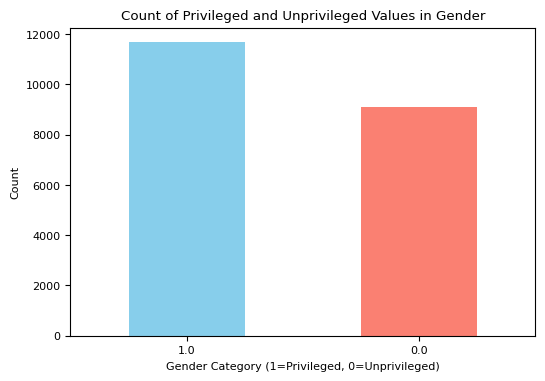

In [74]:
# Count the occurrences of privileged and unprivileged values
gender_counts = df_bank['gender'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
gender_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Privileged and Unprivileged Values in Gender')
plt.xlabel('Gender Category (1=Privileged, 0=Unprivileged)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [75]:
y_counts = df_bank['y'].value_counts()

KeyError: 'y'

In [76]:
# Count the occurrences of privileged and unprivileged values
label_counts = df_bank['y'].value_counts()

# Plot the bar graph
plt.figure(figsize=(6, 4))
age_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Count of Favorable and Unfavorable Values in Dataset')
plt.xlabel('Label Category (1=Favorable, 0=Unfavorable)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

KeyError: 'y'

In [77]:
df_bank.shape

(20798, 14)

## Display Output

In [ ]:
dataset

In [28]:
priv_metric_orig_copy = priv_metric_orig

In [29]:

priv_metric_orig_copy

defaultdict(float, {'total_priv': 30258.0, 'total_unpriv': 23362.0})

In [30]:
priv_metric_orig

defaultdict(float, {'total_priv': 30258.0, 'total_unpriv': 23362.0})

In [31]:
priv_metric_orig.items()

dict_items([('total_priv', 30258.0), ('total_unpriv', 23362.0)])

In [33]:
priv_metric_orig = priv_metric_orig_copy

In [34]:
orig_metrics.items()

dict_items([('bal_acc', [0.5630705175155558, 0.5913914371312363, 0.580005939056147, 0.563820482033095, 0.5782529066418004, 0.5948833651015937, 0.5782108910427495, 0.5783068783068783, 0.5758529258098224, 0.5923030930967192, 0.5725359366952287, 0.5654678655994269, 0.5631118247097068, 0.5787589327567899, 0.5841626132066489, 0.5755923522752459, 0.5640191897654585, 0.5772980528735723, 0.5862856963362297, 0.5623489419014409, 0.5708534445513509, 0.5825905517924801, 0.567002461647373, 0.5621846404384014, 0.5767694452992019, 0.5718518895402621, 0.56569508826146, 0.5698718658327337, 0.5779248403692777, 0.5811411055580322, 0.581260928501532, 0.5679169932079415, 0.5766549408378638, 0.5557407226721306, 0.564345835937773, 0.5722416876167099, 0.5595936980122174, 0.5855241444344034, 0.5636689279578435, 0.548955137214535]), ('avg_odds_diff', [-0.008272861907185902, -0.008931471720464657, 0.04423751873191528, -0.030601468763187062, 0.020140902514412085, -0.012180239409184918, -0.08086887311116706, 0.034

In [35]:
%matplotlib inline
print('1)\n')
print(DATASET)
print(dataset_orig_train.features.shape[0])

print('2)\n')
priv_metric_orig = {k: [v/N] for (k,v) in priv_metric_orig.items()}
results = [priv_metric_orig]
tr = pd.Series(['orig'], name='num_instance')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

print('3)\n')
favor_metric_orig = {k: [v/N] for (k,v) in favor_metric_orig.items()}
favor_metric_transf = {k: [v/N] for (k,v) in favor_metric_transf.items()}
pd.set_option('display.multi_sparse', False)
results = [favor_metric_orig, favor_metric_transf]
tr = pd.Series(['orig'] + ['transf'], name='dataset')
df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis = 0).set_index([tr])
print(df)

1)

law_gender_aif
2681
2)

              total_priv  total_unpriv
num_instance                          
orig              3024.0        2338.0
3)

         total_favor  total_unfavor  priv_favor  priv_unfavor  unpriv_favor  \
dataset                                                                       
orig        0.595487       1.404513    0.612735      1.387265      0.572949   
transf      0.612533       1.387467    0.612735      1.387265      0.612274   

         unpriv_unfavor  
dataset                  
orig           1.427051  
transf         1.387726  


In [36]:
orig_metrics.items()

dict_items([('bal_acc', [0.5630705175155558, 0.5913914371312363, 0.580005939056147, 0.563820482033095, 0.5782529066418004, 0.5948833651015937, 0.5782108910427495, 0.5783068783068783, 0.5758529258098224, 0.5923030930967192, 0.5725359366952287, 0.5654678655994269, 0.5631118247097068, 0.5787589327567899, 0.5841626132066489, 0.5755923522752459, 0.5640191897654585, 0.5772980528735723, 0.5862856963362297, 0.5623489419014409, 0.5708534445513509, 0.5825905517924801, 0.567002461647373, 0.5621846404384014, 0.5767694452992019, 0.5718518895402621, 0.56569508826146, 0.5698718658327337, 0.5779248403692777, 0.5811411055580322, 0.581260928501532, 0.5679169932079415, 0.5766549408378638, 0.5557407226721306, 0.564345835937773, 0.5722416876167099, 0.5595936980122174, 0.5855241444344034, 0.5636689279578435, 0.548955137214535]), ('avg_odds_diff', [-0.008272861907185902, -0.008931471720464657, 0.04423751873191528, -0.030601468763187062, 0.020140902514412085, -0.012180239409184918, -0.08086887311116706, 0.034

In [37]:
print('4)\n')
# dataframe to display fairness metrics
# error metrics
orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in orig_metrics.items()}
transf_error_metrics = {k: [statistics.stdev(v)] for (k,v) in transf_metrics.items()}
reweigh_error_metrics = {k: [statistics.stdev(v)] for (k,v) in reweigh_metrics.items()}
dir_error_metrics = {k: [statistics.stdev(v)] for (k,v) in dir_metrics.items()}
eg_error_metrics = {k: [statistics.stdev(v)] for (k,v) in eg_metrics.items()}
# pr_orig_error_metrics = {k: [statistics.stdev(v)] for (k,v) in pr_orig_metrics.items()}
# cpp_error_metrics = {k: [statistics.stdev(v)] for (k,v) in cpp_metrics.items()}
# ro_error_metrics = {k: [statistics.stdev(v)] for (k,v) in ro_metrics.items()}

# mean value metrics
orig_metrics_mean = {k: [sum(v)/N] for (k,v) in orig_metrics.items()}
transf_metrics_mean = {k: [sum(v)/N] for (k,v) in transf_metrics.items()}
reweigh_metrics_mean = {k:[sum(v)/N] for (k,v) in reweigh_metrics.items()}
dir_metrics_mean = {k:[sum(v)/N] for (k,v) in dir_metrics.items()}
eg_metrics_mean = {k:[sum(v)/N] for (k,v) in eg_metrics.items()}
# pr_orig_metrics_mean = {k: [sum(v)/N] for (k,v) in pr_orig_metrics.items()}
# cpp_metrics_mean = {k: [sum(v)/N] for (k,v) in cpp_metrics.items()}
# ro_metrics_mean = {k: [sum(v)/N] for (k,v) in ro_metrics.items()}

# Python paired sample t-test
from scipy.stats import ttest_rel
def paired_t (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    s, p = ttest_rel(np.absolute(np_a), np.absolute(np_b))
    return p

def acc_diff (a, b):
    np_a = np.array(a)
    np_b = np.array(b)
    delta = np_a - np_b
    m = statistics.mean(delta)
    s = statistics.stdev(delta)
    return [m, s]

# if BASELINE == 'lr':
#     plot_algo_lr(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, pr_orig_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, pr_orig_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print("5)")
#     print(stat)
# else:
#     plot_algo(orig_metrics_mean, transf_metrics_mean, dir_metrics_mean, reweigh_metrics_mean, eg_metrics_mean, cpp_metrics_mean, ro_metrics_mean, orig_error_metrics, transf_error_metrics, dir_error_metrics, reweigh_error_metrics, egr_error_metrics, cpp_error_metrics, ro_error_metrics, BASELINE)
#     stat =  {k: [paired_t(transf_metrics[k], v)] for (k,v) in orig_metrics.items()}
#     print(stat)

# plt.show()

4)



# Visualization

### Fairness

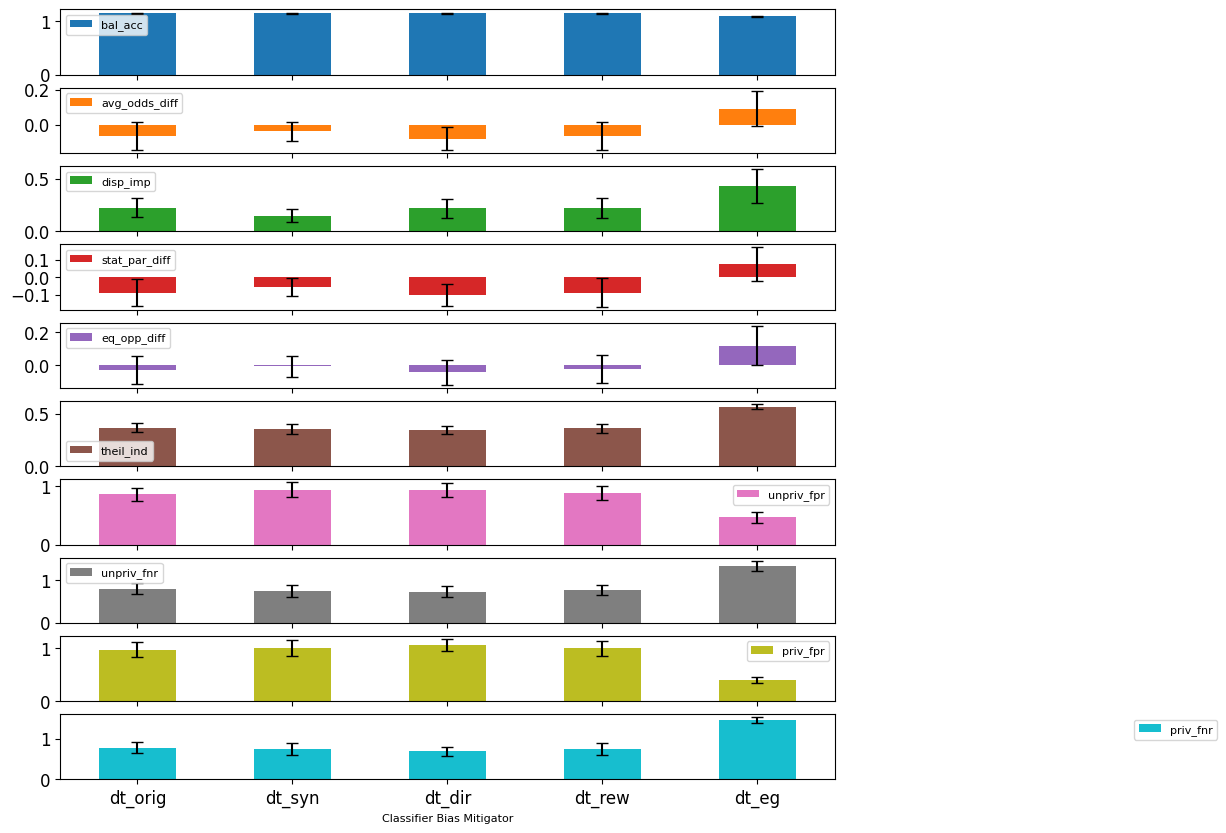

In [38]:
model_type = BASELINE
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_metrics_mean,
        transf_metrics_mean,
        dir_metrics_mean,
        reweigh_metrics_mean,
        eg_metrics_mean]
#         pr_orig_metrics_mean,
#         cpp_metrics_mean,
#         ro_metrics_mean]


errors = [orig_error_metrics,
        transf_error_metrics,
        dir_error_metrics,
        reweigh_error_metrics,
        eg_error_metrics]
#         pr_orig_error_metrics,
#         cpp_error_metrics,
#         ro_error_metrics]

index = pd.Series([model_type+'_orig']+ [model_type+'_syn'] + [model_type+'_dir'] + [model_type+'_rew'] + [model_type+'_eg'], name='Classifier Bias Mitigator')
#                   + [model_type+'_rew']+  + [model_type+'_cpp'], name='Classifier Bias Mitigator')

df = pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index(index)
df_error = pd.concat([pd.DataFrame(metrics) for metrics in errors], axis=0).set_index(index)
ax = df.plot.bar(yerr=df_error, capsize=4, rot=0, subplots=True, title=['','','','','', '', '', '', '', ''], fontsize = 12, figsize=(10,10))
plot1 = ax[0]
plot1.set_ylim=([0, 0.8])
plot2 = ax[1]
plot2.set_ylim=([-0.5, 0])
plot3 = ax[2]
plot3.set_ylim=([0, 1])
plot4 = ax[3]
plot4.set_ylim=([-0.5, 0])
plot5 = ax[4]
plot5.set_ylim=([-0.5, 0])
plot5 = ax[5]
plot5.set_ylim=([0, 0.2])

plt.legend(bbox_to_anchor=(1.5, 1.0))

## Visualization of MIA results

### Visualization of MIA Attacks against various Fairness Techniques

#### Privacy risk subpopulations vs Fairness with cross validation

In [47]:
# dataframe to display fairness metrics
# error metrics
%matplotlib inline
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in cpp_metrics.items() if k.endswith("_mia_privacy_risk")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
# cpp_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}

In [40]:
# Visualization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
           transf_mia_metrics_mean,
           dir_mia_metrics_mean,
           reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
          ]


errors = [orig_mia_error_metrics,
          transf_mia_error_metrics,
          dir_mia_error_metrics,
          reweigh_mia_error_metrics,
          eg_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn'] + ['dir'] + ['rew'] + ['eg'], name='Classifier MIA Attacks')
#                   + ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

,entire_dataset_mia_privacy_risk,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,,
orig,1.070822,1.069401,1.162185,1.076961,1.156504
syn,1.071233,1.070739,1.164522,1.073125,1.154720
dir,1.078646,1.078472,1.181473,1.086515,1.164952
rew,1.071000,1.069132,1.160067,1.077194,1.157615
eg,1.075615,1.077534,1.182641,1.084248,1.188491


In [46]:
orig_mia_metrics

defaultdict(list,
            {'entire_dataset_mia_auc': [0.5606676404515955,
              0.5427336134298288,
              0.5458320052656175,
              0.5501774474693858,
              0.543438631306745,
              0.5428863035373602,
              0.5449908532017133,
              0.5384976629022584,
              0.547034952887276,
              0.5398175454080902,
              0.5451984282727262,
              0.5523974712013935,
              0.5511065267751668,
              0.5424571017316797,
              0.5334353076013518,
              0.5494537867911857,
              0.5464017932705331,
              0.5496893956268161,
              0.5435211326586957,
              0.5476773643419697,
              0.5431326945901512,
              0.5276810817721959,
              0.5499846196889407,
              0.553464841137595,
              0.5528415594230247,
              0.5554325609880462,
              0.5438057136290425,
              0.5414765460342936,
       

In [41]:
df.columns

Index(['entire_dataset_mia_privacy_risk',
       'subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk'],
      dtype='object')

In [42]:
df_groups = df[['subpopulation_0.0_label_0.0_mia_privacy_risk',
       'subpopulation_0.0_label_1.0_mia_privacy_risk',
       'subpopulation_1.0_label_0.0_mia_privacy_risk',
       'subpopulation_1.0_label_1.0_mia_privacy_risk']]

In [43]:
df_groups

,subpopulation_0.0_label_0.0_mia_privacy_risk,subpopulation_0.0_label_1.0_mia_privacy_risk,subpopulation_1.0_label_0.0_mia_privacy_risk,subpopulation_1.0_label_1.0_mia_privacy_risk
Classifier MIA Attacks,,,,
orig,1.069401,1.162185,1.076961,1.156504
syn,1.070739,1.164522,1.073125,1.154720
dir,1.078472,1.181473,1.086515,1.164952
rew,1.069132,1.160067,1.077194,1.157615
eg,1.077534,1.182641,1.084248,1.188491


<Axes: xlabel='Classifier MIA Attacks'>

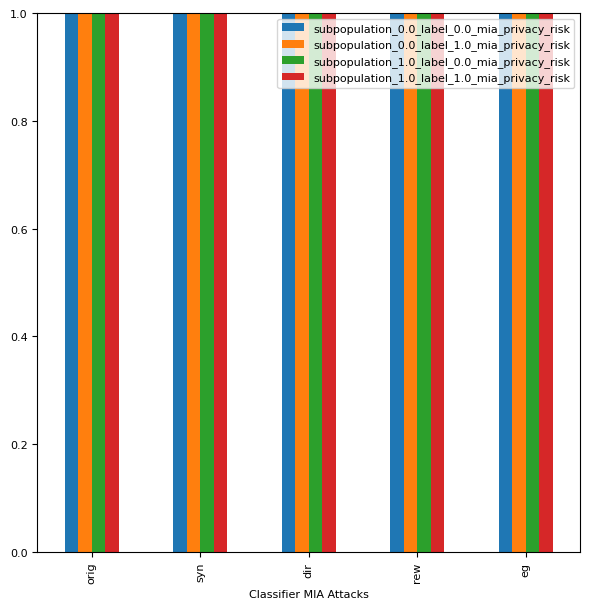

In [44]:
df_groups.plot.bar(figsize=(7,7), ylim=[0,1])

In [45]:
# Tabular Format
# importing the modules
from tabulate import tabulate

 
# displaying the DataFrame
print(tabulate(df_groups.T, headers = 'keys', tablefmt = 'simple'))

                                                 orig      syn      dir      rew       eg
--------------------------------------------  -------  -------  -------  -------  -------
subpopulation_0.0_label_0.0_mia_privacy_risk  1.0694   1.07074  1.07847  1.06913  1.07753
subpopulation_0.0_label_1.0_mia_privacy_risk  1.16218  1.16452  1.18147  1.16007  1.18264
subpopulation_1.0_label_0.0_mia_privacy_risk  1.07696  1.07312  1.08652  1.07719  1.08425
subpopulation_1.0_label_1.0_mia_privacy_risk  1.1565   1.15472  1.16495  1.15761  1.18849


### Visualizing using novel technique

In [95]:
orig_mia_error_metrics = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
eg_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("_mia_privacy_risk")}
#orig_mia_metrics

In [96]:
advantage_metrics_arrays = []
for key in orig_mia_error_metrics.keys():
    for val in orig_mia_metrics[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in eg_mia_error_metrics.keys():
    for val in eg_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["eg", key.replace("_mia_attacker_advantage", ""), val])

In [97]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "Privacy Risk"])
df

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.517117
1,orig,entire_dataset_mia_privacy_risk,0.517982
2,orig,entire_dataset_mia_privacy_risk,0.517550
3,orig,entire_dataset_mia_privacy_risk,0.521300
4,orig,entire_dataset_mia_privacy_risk,0.524954
...,...,...,...
695,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.504434
696,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.505321
697,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.502599
698,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.503012


In [98]:
# keep only subgroups
df_subgroups = df[~((df["MIA"] == "entire_dataset_label_0.0_mia_privacy_risk") | (df["MIA"] == "entire_dataset_label_1.0_mia_privacy_risk")) ]
df_subgroups

,Fairness,MIA,Privacy Risk
0,orig,entire_dataset_mia_privacy_risk,0.517117
1,orig,entire_dataset_mia_privacy_risk,0.517982
2,orig,entire_dataset_mia_privacy_risk,0.517550
3,orig,entire_dataset_mia_privacy_risk,0.521300
4,orig,entire_dataset_mia_privacy_risk,0.524954
...,...,...,...
695,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.504434
696,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.505321
697,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.502599
698,eg,subpopulation_1.0_label_1.0_mia_privacy_risk,0.503012


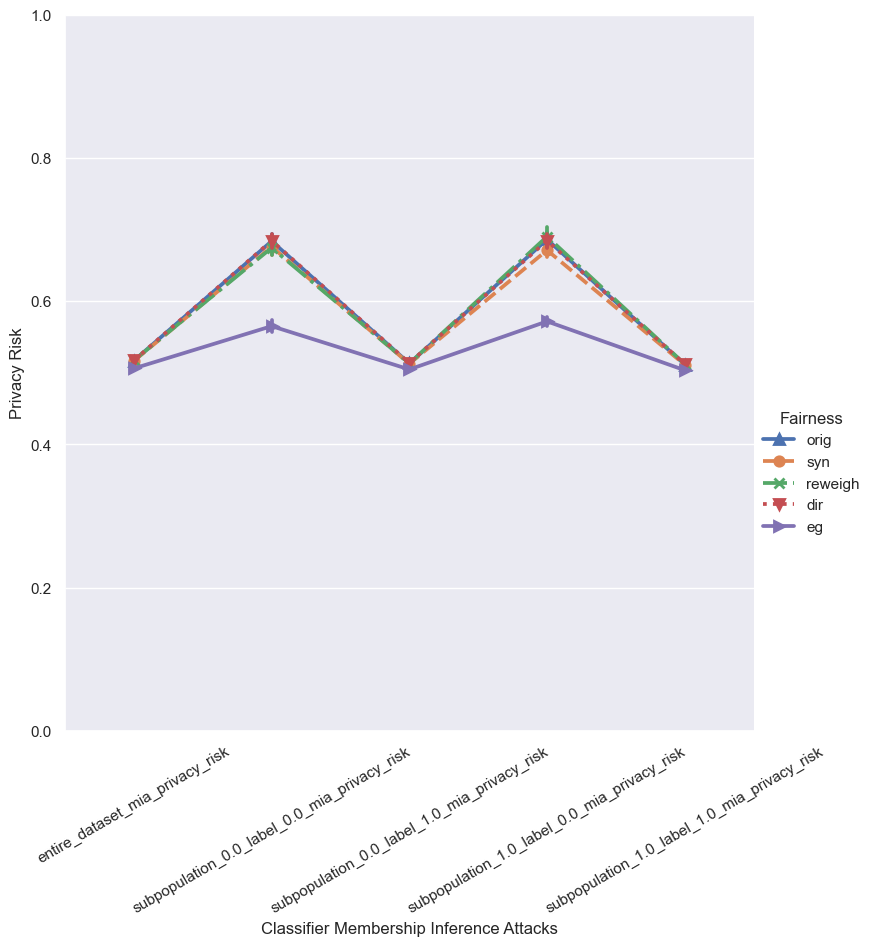

In [99]:
#plt.figure(figsize=(15,8))
import seaborn as sns

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df_subgroups, x="MIA", y="Privacy Risk", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Privacy Risk" )
g.set(ylim=(0, 1))

### ROC curves and AUC scores with cross validation

In [100]:
from sklearn.metrics import RocCurveDisplay, auc

In [101]:
orig_mia_metrics.keys()

dict_keys(['entire_dataset_mia_auc', 'entire_dataset_mia_privacy_risk', 'entire_dataset_mia_ppv', 'entire_dataset_mia_attacker_advantage', 'entire_dataset_mia_result', 'entire_dataset_label_0.0_mia_auc', 'entire_dataset_label_0.0_mia_privacy_risk', 'entire_dataset_label_0.0_mia_ppv', 'entire_dataset_label_0.0_mia_attacker_advantage', 'entire_dataset_label_0.0_mia_result', 'entire_dataset_label_1.0_mia_auc', 'entire_dataset_label_1.0_mia_privacy_risk', 'entire_dataset_label_1.0_mia_ppv', 'entire_dataset_label_1.0_mia_attacker_advantage', 'entire_dataset_label_1.0_mia_result', 'subpopulation_0.0_label_0.0_mia_auc', 'subpopulation_0.0_label_0.0_mia_privacy_risk', 'subpopulation_0.0_label_0.0_mia_ppv', 'subpopulation_0.0_label_0.0_mia_attacker_advantage', 'subpopulation_0.0_label_0.0_mia_result', 'subpopulation_0.0_label_1.0_mia_auc', 'subpopulation_0.0_label_1.0_mia_privacy_risk', 'subpopulation_0.0_label_1.0_mia_ppv', 'subpopulation_0.0_label_1.0_mia_attacker_advantage', 'subpopulation_0

In [ ]:
# for orig dataset with different subpopulations
fig, ax = plt.subplots(figsize=(10, 8))

for key in ["entire_dataset_mia_result", 
            "subpopulation_0.0_label_0.0_mia_result",
            "subpopulation_0.0_label_1.0_mia_result", 
            "subpopulation_1.0_label_0.0_mia_result",
            "subpopulation_1.0_label_1.0_mia_result"]:
     # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
    # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
    tprs = []
    
    # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
    aucs = []

    # mean_fpr = np.mean(fprs, axis=0)
    mean_fpr = np.linspace(0, 1, 100)
    
    for mia_res in orig_mia_metrics[key]:
        interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(mia_res.get_auc())
    
    #print(mean_fpr)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    ax.plot(
        mean_fpr,
        mean_tpr,
        #color="b",
        label=r"Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % ( key ,mean_auc, std_auc),
        lw=2,
        alpha=0.8,
    )

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        #label=r"$\pm$ 1 std. dev.",
    )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve with variability",
)
ax.legend(loc="lower right")
plt.show()

In [ ]:
# for entire dataset with different subpopulations
# fig, ax = plt.subplots(figsize=(12, 10))
fig, ax = plt.subplots(figsize=(24, 18))

for mia_metrics, name in zip([orig_mia_metrics, transf_mia_metrics], ["orig", "syn"]): 
#                               dir_mia_metrics, reweigh_mia_metrics], ["orig", "syn", "dir", "reweigh"] ):
    for key in ["entire_dataset_mia_result", 
                "subpopulation_0.0_label_0.0_mia_result",
                "subpopulation_0.0_label_1.0_mia_result", 
                "subpopulation_1.0_label_0.0_mia_result",
                "subpopulation_1.0_label_1.0_mia_result"]:
   
        # fprs = [mia_res.fpr for mia_res in orig_mia_metrics[key]]
        # tprs = [mia_res.tpr for mia_res in orig_mia_metrics[key]]
        tprs = []
        # aucs = [mia_res.get_auc() for mia_res in orig_mia_metrics[key]]
        aucs = []

        # mean_fpr = np.mean(fprs, axis=0)
        mean_fpr = np.linspace(0, 1, 100)

        for mia_res in mia_metrics[key]:
            print(mia_res)
            interp_tpr = np.interp(mean_fpr, mia_res.fpr, mia_res.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(mia_res.get_auc())

        #print(mean_fpr)
        print(tprs)
        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0

        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)

        ax.plot(
            mean_fpr,
            mean_tpr,
            #color="b",
            label=r"%s Mean ROC for %s $\pm$ 1 std. dev. (AUC = %0.2f $\pm$ %0.2f)" % (name, key ,mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        ax.fill_between(
            mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            #label=r"$\pm$ 1 std. dev.",
        )


plt.plot([0, 1], [0, 1],'k--', alpha=0.5)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title=f"Mean ROC curve for MIA attacks against Fairness Approaches",
)
ax.legend(loc="lower right")
# ax.legend(loc="upper left")

plt.show()

In [ ]:
# for entire dataset
plt.figure(figsize=(10,8))

for mia_res in orig_mia_metrics["entire_dataset_mia_result"]:
    plt.plot(mia_res.fpr,mia_res.tpr,label=f"{mia_res.get_name()} auc={mia_res.get_auc()}")

plt.plot([0, 1], [0, 1],'k--', alpha=0.5)
plt.legend(loc=0)

## MIA Attacks AUC vs Fairness Bar Chart 

In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("mia_auc")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("mia_auc")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("mia_auc")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("mia_auc")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("mia_auc")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_auc")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("mia_auc")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("mia_auc")}

In [ ]:
orig_mia_metrics_mean

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
        eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

In [ ]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

###  MIA Attackers Advantage Metrics

In [ ]:
# Creating data structures to plot point categorical plot from seaborn

In [ ]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [ ]:
orig_mia_metrics_att_ad

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_attacker_advantage", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_attacker_advantage", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_attacker_advantage", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_attacker_advantage", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_attacker_advantage", ""), val])
advantage_metrics_arrays

In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "attacker_advantage"])
df

In [ ]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)
g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )


In [ ]:
#plt.figure(figsize=(15,8))

sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="attacker_advantage", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)
plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's Advantage" )
g.set(ylim=(0, 1))

In [ ]:
pd.DataFrame(orig_mia_metrics_att_ad)

In [ ]:
# dataframe to display fairness metrics
# error metrics
orig_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in reweigh_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in dir_metrics.items() if k.endswith("attacker_advantage")}
egr_mia_error_metrics = {k: statistics.stdev(v) for (k,v) in eg_metrics.items() if k.endswith("attacker_advantage")}

# mean value metrics
orig_mia_metrics_mean = {k: sum(v)/N for (k,v) in orig_mia_metrics.items() if k.endswith("attacker_advantage")}
transf_mia_metrics_mean = {k: sum(v)/N for (k,v) in transf_mia_metrics.items() if k.endswith("attacker_advantage")}
reweigh_mia_metrics_mean = {k:sum(v)/N for (k,v) in reweigh_mia_metrics.items() if k.endswith("attacker_advantage")}
dir_mia_metrics_mean = {k:sum(v)/N for (k,v) in dir_mia_metrics.items() if k.endswith("attacker_advantage")}
eg_mia_metrics_mean = {k:sum(v)/N for (k,v) in eg_mia_metrics.items() if k.endswith("attacker_advantage")}

In [ ]:
orig_mia_metrics_mean

In [ ]:
# Visuazlization of Fairness
pd.set_option('display.multi_sparse', False)
plt.rcParams.update({'font.size': 8}) # must set in top

results = [orig_mia_metrics_mean,
        transf_mia_metrics_mean,
        dir_mia_metrics_mean,
        reweigh_mia_metrics_mean,
           eg_mia_metrics_mean
        ]


errors = [orig_mia_error_metrics,
        transf_mia_error_metrics,
        dir_mia_error_metrics,
        reweigh_mia_error_metrics,
          egr_mia_error_metrics
         ]

index = pd.Series(['orig']+ ['syn']+ ['dir']+ ['rew'] + ['egr'], name='Classifier MIA Attacks')

df = pd.DataFrame(results).set_index(index)
df

In [ ]:
df.plot.bar(figsize=(7,7), ylim=[0,1])

## PPV Metric

In [ ]:
orig_mia_metrics_att_ad = {k: v for (k,v) in orig_mia_metrics.items() if k.endswith("mia_ppv")}
transf_mia_error_metrics = {k: v for (k,v) in transf_mia_metrics.items() if k.endswith("mia_ppv")}
reweigh_mia_error_metrics = {k: v for (k,v) in reweigh_mia_metrics.items() if k.endswith("mia_ppv")}
dir_mia_error_metrics = {k: v for (k,v) in dir_mia_metrics.items() if k.endswith("mia_ppv")}
egr_mia_error_metrics = {k: v for (k,v) in eg_mia_metrics.items() if k.endswith("mia_ppv")}

In [ ]:
advantage_metrics_arrays = []
for key in orig_mia_metrics_att_ad.keys():
    for val in orig_mia_metrics_att_ad[key]:
        advantage_metrics_arrays.append(["orig", key.replace("_mia_ppv", ""), val])
for key in transf_mia_error_metrics.keys():
    for val in transf_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["syn", key.replace("_mia_ppv", ""), val])
for key in reweigh_mia_error_metrics.keys():
    for val in reweigh_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["reweigh", key.replace("_mia_ppv", ""), val])
for key in dir_mia_error_metrics.keys():
    for val in dir_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["dir", key.replace("_mia_ppv", ""), val])
for key in egr_mia_error_metrics.keys():
    for val in egr_mia_error_metrics[key]:
        advantage_metrics_arrays.append(["egr", key.replace("_mia_ppv", ""), val])
advantage_metrics_arrays

In [ ]:
df = pd.DataFrame(advantage_metrics_arrays,columns=["Fairness", "MIA", "PPV"])
df

In [ ]:
# Plotting without scaling y limis to 1
import seaborn as sns
sns.set_theme()
#sns.set_style('ticks')

g = sns.catplot(
    data=df, x="MIA", y="PPV", hue="Fairness",
    #palette={"male": "g", "female": "m"},
    markers=["^", "o", "x", "v", ">"], linestyles=["-", "--", "-.", ":", "-"],
    kind="point", height=8, aspect=1
)

plt.xticks(rotation=30)

g.set_axis_labels("Classifier Membership Inference Attacks", "Attacker's PPV" )


# Dataset Exploration for comparison with Shokri

In [ ]:
import pandas as pd

In [ ]:
# pd.DataFrame([dataset_orig.features, dataset_orig.labels]).drop_duplicates()

df = pd.DataFrame(dataset_orig.features, columns=dataset_orig.feature_names)

df["labels"] = dataset_orig.labels
df
#df.index

In [ ]:
df[["age", "labels"]].value_counts(normalize=True)

In [ ]:
df.drop_duplicates()

## DT Accuracy

In [ ]:
get_orig_model_metrics(dataset_orig_train, dataset_orig_test, unprivileged_groups, f_label, uf_label, BASELINE, SCALER, ATTACK)

In [ ]:
# train_test_egr